In [14]:
import concurrent.futures
from typing import Dict, List
import glob
import os
import multiprocessing

from gesim import gesim
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.Scaffolds import MurckoScaffold 
import seaborn as sns


In [6]:
df_id_smi = pd.read_csv('data/zinc20_1k_random_sample.smi', delimiter=' ',header=None)
df_id_smi[0]

0      OC[C@@H]1O[C@@H](n2cnc3c(NCCc4ccc(O)c(O)c4)ncn...
1        CN(C)C(=O)c1ccc(/N=N/c2c(O)[nH]c3ccccc3c2=O)cc1
2      CN[C@@H]1[C@H](O[C@@H]2[C@@H](O[C@H]3[C@@H](NC...
3               CCO[C@H]1COC[C@@H]1NC(=O)c1nn(C)c(C)c1Cl
4      NC(=O)C1=C[C@@]2([N+](=O)[O-])CN(CC(=O)O)C[C@@...
                             ...                        
995    COC(=O)C[C@H]1C(=O)NCCN1c1nc2c(C)cccn2c(=O)c1/...
996    O=C(COC(=O)[C@@H]1CC(=O)N(NC(=O)c2ccccc2[N+](=...
997    CCOc1cccc(N2C(=O)/C(=C\c3cc([N+](=O)[O-])cc([N...
998                             OC1=CC=C[C@]2(O)S[C@H]12
999    Cc1nn(Cc2ccccc2Cl)c(C)c1NC(=O)CSc1[nH]nc(C)c1[...
Name: 0, Length: 1000, dtype: object

In [7]:
df_id_smi = pd.read_csv('data/LIT-PCBA/map_gid2smiles_zinc20_vgic.txt', delimiter=" ", header=None)
df_id_smi['mol'] = df_id_smi[1].apply(lambda x: Chem.MolFromSmiles(x))
df_id_smi['fp'] = df_id_smi['mol'].apply(lambda x: AllChem.GetMorganFingerprint(x, 2))
df_id_smi['graph'] = df_id_smi['mol'].apply(lambda x: gesim.get_graph_from_mol(x))

pair_idxs = []
for i in range(df_id_smi.shape[0]):
    pair_idxs.extend([f"{i}_{n}" for n in range(df_id_smi.shape[0])])


In [8]:
tanimoto_sims = []
for i in range(df_id_smi.shape[0]):
    #fp = ##
    tsims = DataStructs.BulkTanimotoSimilarity(df_id_smi['fp'][i], df_id_smi['fp'].tolist())
    tanimoto_sims.extend(tsims)

In [9]:
ge_sims_r4 = []
for i in range(df_id_smi.shape[0]):
    gesims = gesim.graph_entropy_similarity_batch(df_id_smi['graph'][i], df_id_smi['graph'].tolist(), r=4)
    ge_sims_r4.extend(gesims)

In [12]:
ge_sims_r4[:15]

[1.0,
 0.19753600330427878,
 0.18221642503658597,
 0.18332383603098057,
 0.1861609772279056,
 0.17625445616191848,
 0.17926516598608677,
 0.18827250521344785,
 0.18108821024812116,
 0.17648548967697497,
 0.17462962347456346,
 0.18332383603098057,
 0.1903172334126807,
 0.14234942068147904,
 0.19091582362248172]

<Axes: xlabel='graphsim', ylabel='tanimoto'>

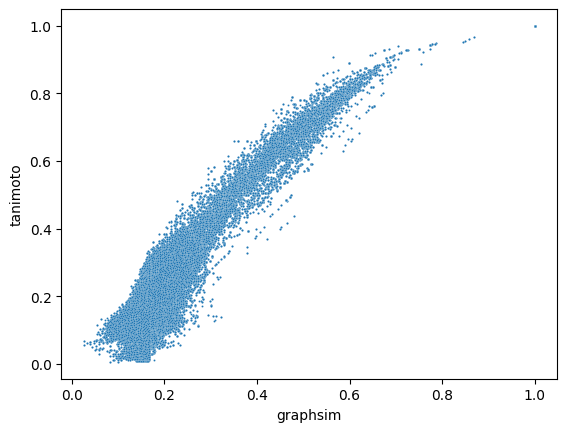

In [13]:
df_vis = pd.DataFrame({
    'pair_id': pair_idxs,
    'tanimoto': tanimoto_sims, 
    'graphsim': ge_sims_r4,
})
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=df_vis, x='graphsim', y='tanimoto', s=2)

In [15]:
def calculate_batch_tanimoto_similarity(mols):
    ref_mol = mols[0]
    for m in mols:
        ref_fp = AllChem.GetMorganFingerprintAsBitVect(ref_mol, radius=2, nBits=2048)
        fp = AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048)
        _ = DataStructs.TanimotoSimilarity(ref_fp, fp)

def calculate_batch_gesim(mols):
    ref_mol = mols[0]
    for m in mols:
        _ = gesim.graph_entropy_similarity(ref_mol, m)
        
        

def calculate_ged(g1, g2):
    return nx.graph_edit_distance(g1, g2, edge_match=lambda a, b: a['weight'] == b['weight'])


def get_graph(mol):
    Chem.Kekulize(mol)
    atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    am = Chem.GetAdjacencyMatrix(mol, useBO=True)
    for i, atom in enumerate(atoms):
        am[i, i] = atom
    G = nx.from_numpy_array(am)
    return G

def calculate_ged_with_timeout(g1, g2, timeout_seconds):
    with multiprocessing.Pool(1) as pool:
        result_async = pool.apply_async(calculate_ged, (g1, g2))
        try:
            return result_async.get(timeout=timeout_seconds)
        except multiprocessing.TimeoutError:
            #print("Timeout")
            return None

def calculate_batch_ged(mols, timeout_sec=5):
    timeout_cnt = 0
    ref_mol = mols[0]

    for m in mols:
        g1 = get_graph(ref_mol)
        g2 = get_graph(m)
        result = calculate_ged_with_timeout(g1, g2, timeout_sec)
        if result is not None:
            print(f"Graph Edit Distance: {result}")
        else:
            timeout_cnt += 1
    print(f"timeout count: {timeout_cnt}, total count {len(mols)}")

In [16]:
zinc_mols = df_id_smi['mol'].tolist()

In [17]:
calculate_batch_tanimoto_similarity(zinc_mols)

In [18]:
calculate_batch_gesim(zinc_mols)

In [19]:
calculate_batch_ged(zinc_mols, timeout_sec=10)

Graph Edit Distance: 0.0


timeout count: 999, total count 1000


In [136]:
class ResultContent():
    def __init__(self):
        self.result_stat =  {
            'mean': {
                'enrichment_factor': [],
                'BEDROC': [],
                'AUC': [],
                'scaffold_enrichment_factor': []}, 
            'std': {
                'enrichment_factor': [],
                'BEDROC': [],
                'AUC': [],
                'scaffold_enrichment_factor': []}
            } 

def calculate_stat(result_dict: Dict[str, float], target_labels: List[str], output_dict: Dict[str, float]) -> None:
    for label in target_labels:
        for k, v in result_dict[label].items():
            output_dict['mean'][k].append(np.mean(v))
            output_dict['std'][k].append(np.std(v))


def plot_scatter_with_errorbar(result_stat1, result_stat2, index_name, labels, label_scores, xlabel=None, ylabel=None, title=None, ef_x=None):
    """ef_x = 005, 001"""
    x = result_stat1['mean'][index_name]
    y = result_stat2['mean'][index_name]
    xerr = result_stat1['std'][index_name]
    yerr = result_stat2['std'][index_name]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    
    if index_name == "enrichment_factor" or index_name == "scaffold_enrichment_factor":
        if ef_x == "005":
            ax.plot([0, 20], [0, 20], color='lightgray')
        elif ef_x == "001":
            ax.plot([0, 100], [0, 100], color='lightgray')
        else:
            print("Typo. Specify 001 or 005")
    else:
        ax.plot([0, 1], [0, 1], color='lightgray')
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='none', ecolor='lightgray', elinewidth=1.0, capsize=1.0, zorder=2)

    colors = [label_scores.get(label, 0.0) for label in labels]  # NEED TO CALCULATE B/A
    cmap = matplotlib.colormaps['plasma']
    sc = ax.scatter(x, y, c=colors, cmap=cmap, vmin=0.0, vmax=1.0, s=30, zorder=3)
    cbar = plt.colorbar(sc)
    cbar.set_label('Ratio of BMS/Actives')

    #for i, label in enumerate(labels):
    #    if index_name == "enrichment_factor" or index_name == "scaffold_enrichment_factor":
    #        ax.text(x[i]+0.6, y[i]+0.6, label, fontsize=6, color='gray')
    #    else:
    #        ax.text(x[i]+0.01, y[i]+0.01, label, fontsize=6, color='gray')
    ax.set_title(title, fontsize=15, pad=15)
    ax.set_xlabel(f"{xlabel}", fontsize=18, labelpad=10)
    ax.set_ylabel(f"{ylabel}", fontsize=18, labelpad=10)
    
    if index_name == "enrichment_factor" or index_name == "scaffold_enrichment_factor":
        if ef_x == "005":
            ax.set_xlim(-0.05, 20.05)
            ax.set_ylim(-0.05, 20.05)
        elif ef_x == "001":
            ax.set_xlim(-0.05, 100.05)
            ax.set_ylim(-0.05, 100.05)
        else:
            print("Typo. Specify pat1 or pat2")
    else:
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)

    fig.show()

def plot_all_methods_performance(
    tanimoto_stat, gesim_stat, dataset_name, target_labels, label_scores_dict,
    alpha=20, fraction=0.05, gesim_r=4):
    for index_name in ["enrichment_factor", "AUC", "BEDROC", "scaffold_enrichment_factor"]:
        if index_name == "enrichment_factor" or index_name == "scaffold_enrichment_factor":
            if fraction == 0.01:
                title = f"{index_name} (x=0.01) with error bar\n (#trial=50, #sampling/trial=10)"
            elif fraction == 0.05:
                title = f"{index_name} (x=0.05) with error bar\n (#trial=50, #sampling/trial=10)"
            else:
                raise
        elif index_name == "BEDROC":
            if alpha == 100:
                title = f"{index_name} (α=100) with error bar\n (#trial=50, #sampling/trial=10)"
            elif alpha == 20:
                title = f"{index_name} (α=20) with error bar\n (#trial=50, #sampling/trial=10)"
        else:
            title = f"{index_name} with error bar\n (#trial=50, #sampling/trial=10)"
        title = f"{dataset_name}\n" + title
            
        plot_scatter_with_errorbar(
            tanimoto_stat.result_stat,
            gesim_stat.result_stat,
            index_name,
            target_labels,
            label_scores_dict,
            xlabel="Tanimoto similarity\n(r=2, 2048 dim.)",
            ylabel=f"GESim\n(r={gesim_r})",
            title=title,
            ef_x=str(fraction).replace('.', ''))

In [140]:
all_active_fnames = glob.glob("./data/benchmarking_platform/compounds/*/*/actives.smi")
target_ba_ratio_dict = {}
for fname in all_active_fnames:
    target_name = os.path.basename(os.path.dirname(fname))
    with open(fname, 'r') as f:
        smiles_list = [l.split(' ')[0] for l in f.readlines()]
        bms_set = set([MurckoScaffold.MurckoScaffoldSmilesFromSmiles(s) for s in smiles_list])
    target_ba_ratio_dict[target_name] = round(len(bms_set) / len(smiles_list), 2)

# MUV

In [134]:
import pickle
dataset_root_dir = "./result/benchmarking_platform/MUV/"

with open(f'{dataset_root_dir}/ge_sim/result_r1_a100_f001.pkl', 'rb') as f:
    ge_r1_a100_f001_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r1_a20_f005.pkl', 'rb') as f:
    ge_r1_a20_f005_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r2_a100_f001.pkl', 'rb') as f:
    ge_r2_a100_f001_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r2_a20_f005.pkl', 'rb') as f:
    ge_r2_a20_f005_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r3_a100_f001.pkl', 'rb') as f:
    ge_r3_a100_f001_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r3_a20_f005.pkl', 'rb') as f:
    ge_r3_a20_f005_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r4_a100_f001.pkl', 'rb') as f:
    ge_r4_a100_f001_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r4_a20_f005.pkl', 'rb') as f:
    ge_r4_a20_f005_result = pickle.load(f)

with open(f'{dataset_root_dir}/tanimoto_sim/result_a100_f001.pkl', 'rb') as f:
    tani_a100_f001_result = pickle.load(f)
with open(f'{dataset_root_dir}/tanimoto_sim/result_a20_f005.pkl', 'rb') as f:
    tani_a20_f005_result = pickle.load(f)

target_labels = list(tani_a100_f001_result.keys())

ge_r1_a100_f001_stat = ResultContent()
ge_r1_a20_f005_stat = ResultContent()
ge_r2_a100_f001_stat = ResultContent()
ge_r2_a20_f005_stat = ResultContent()
ge_r3_a100_f001_stat = ResultContent()
ge_r3_a20_f005_stat = ResultContent()
ge_r4_a100_f001_stat = ResultContent()
ge_r4_a20_f005_stat = ResultContent()

tani_a100_f001_stat = ResultContent()
tani_a20_f005_stat = ResultContent()

calculate_stat(ge_r1_a100_f001_result, target_labels, ge_r1_a100_f001_stat.result_stat)
calculate_stat(ge_r1_a20_f005_result, target_labels, ge_r1_a20_f005_stat.result_stat)
calculate_stat(ge_r2_a100_f001_result, target_labels, ge_r2_a100_f001_stat.result_stat)
calculate_stat(ge_r2_a20_f005_result, target_labels, ge_r2_a20_f005_stat.result_stat)
calculate_stat(ge_r3_a100_f001_result, target_labels, ge_r3_a100_f001_stat.result_stat)
calculate_stat(ge_r3_a20_f005_result, target_labels, ge_r3_a20_f005_stat.result_stat)
calculate_stat(ge_r4_a100_f001_result, target_labels, ge_r4_a100_f001_stat.result_stat)
calculate_stat(ge_r4_a20_f005_result, target_labels, ge_r4_a20_f005_stat.result_stat)
calculate_stat(tani_a100_f001_result, target_labels, tani_a100_f001_stat.result_stat)
calculate_stat(tani_a20_f005_result, target_labels, tani_a20_f005_stat.result_stat)

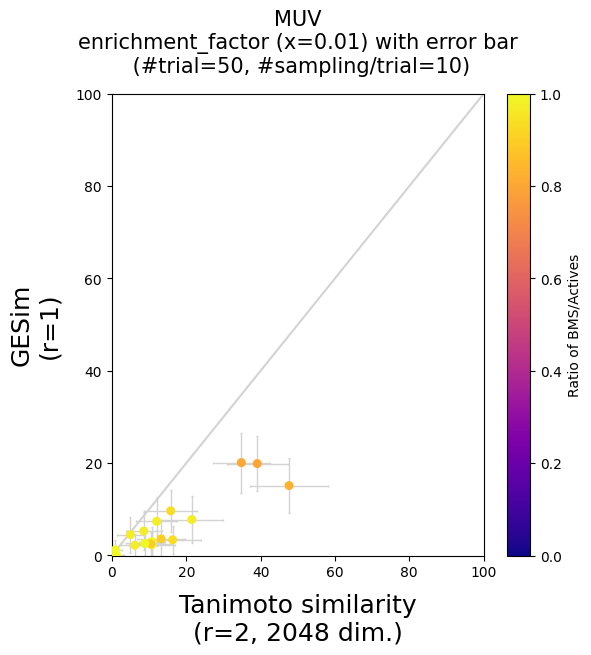

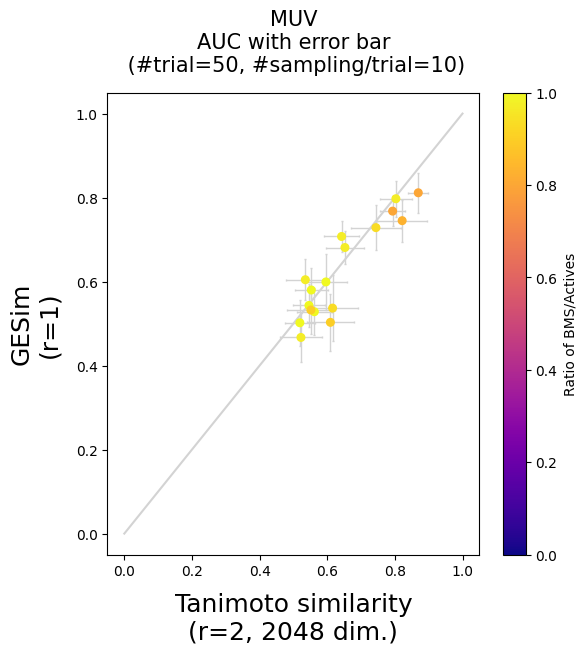

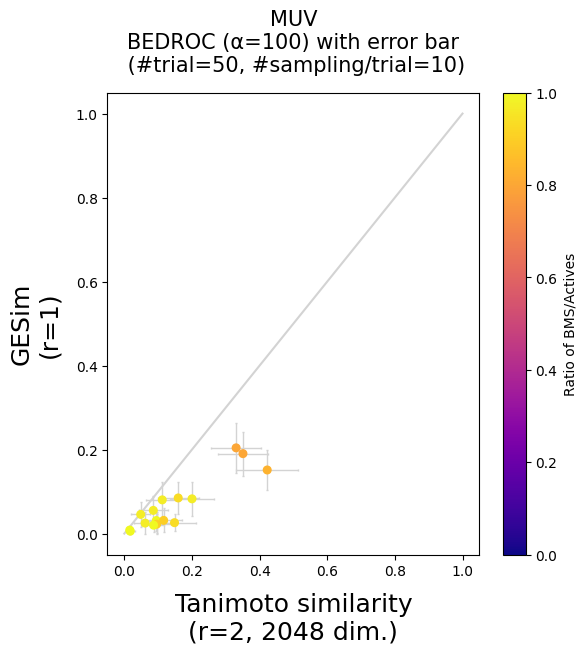

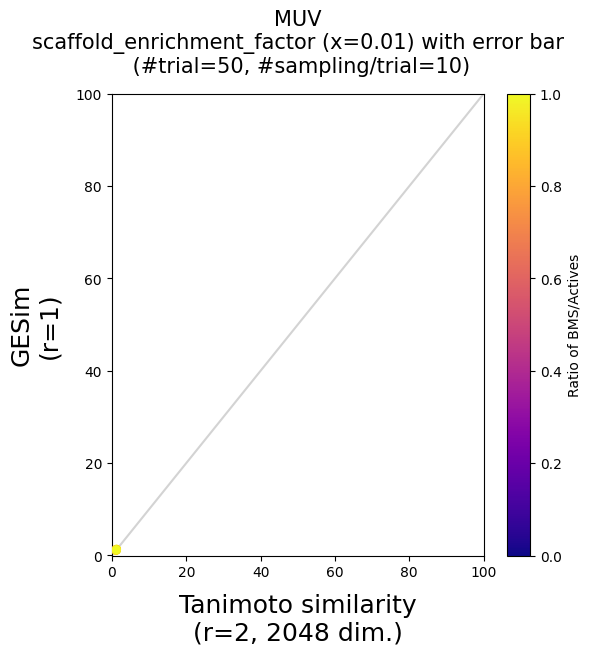

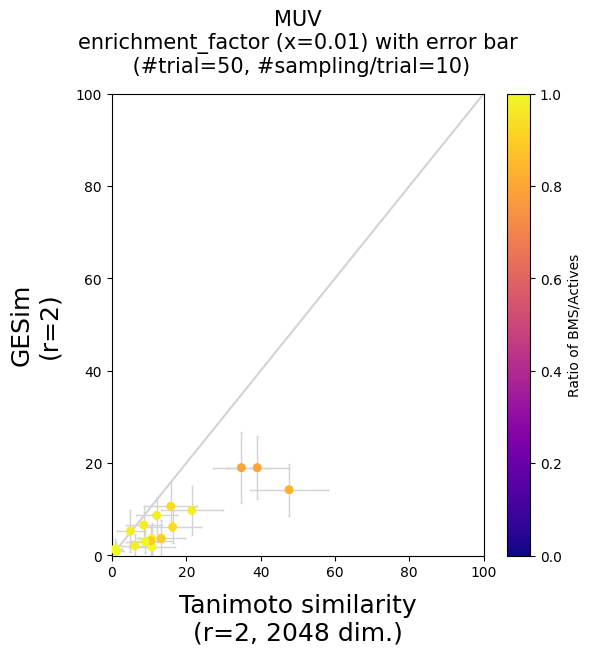

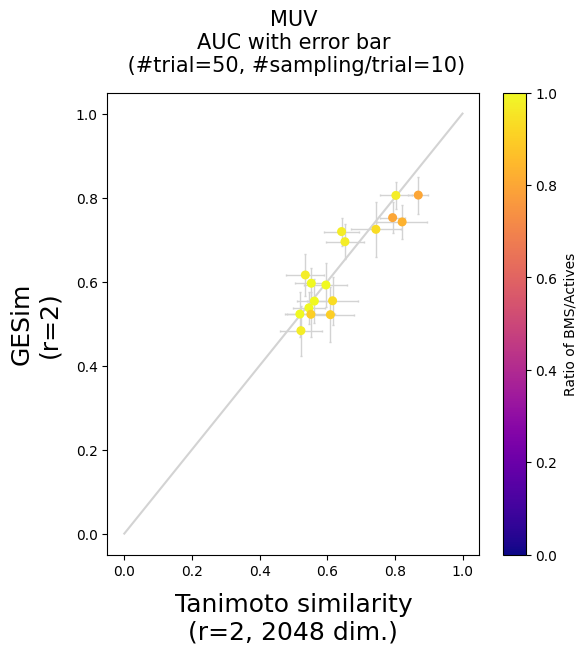

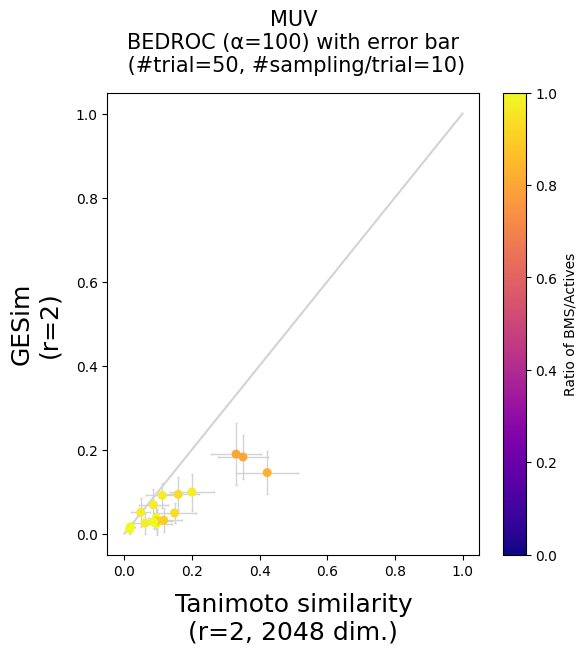

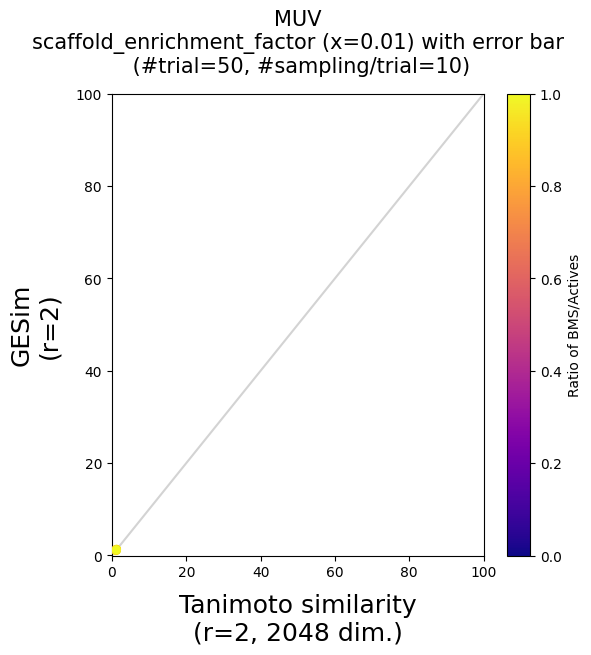

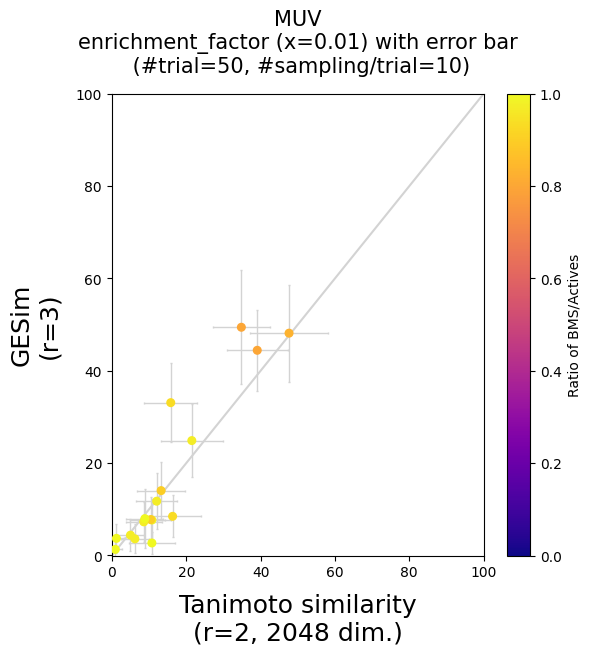

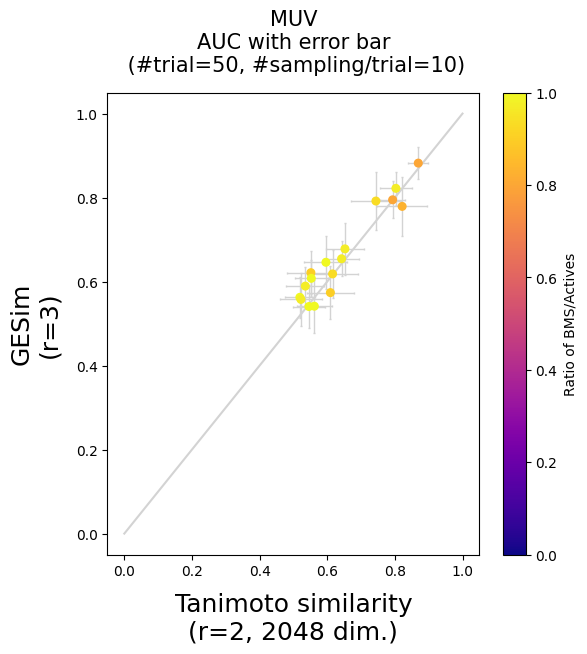

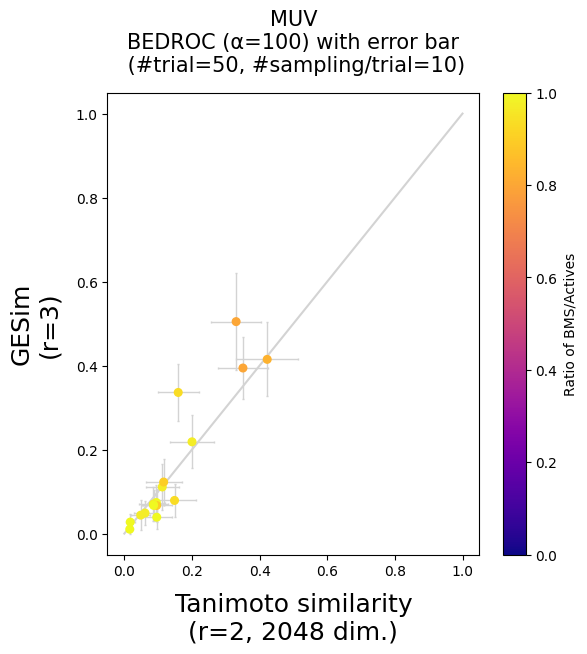

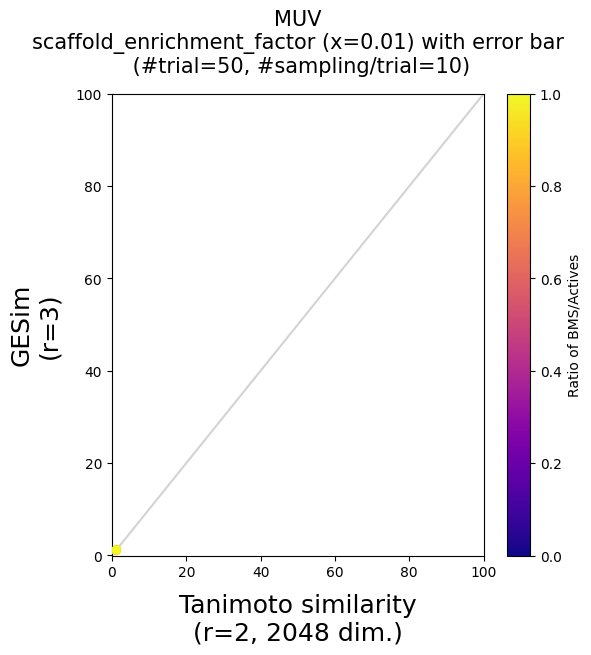

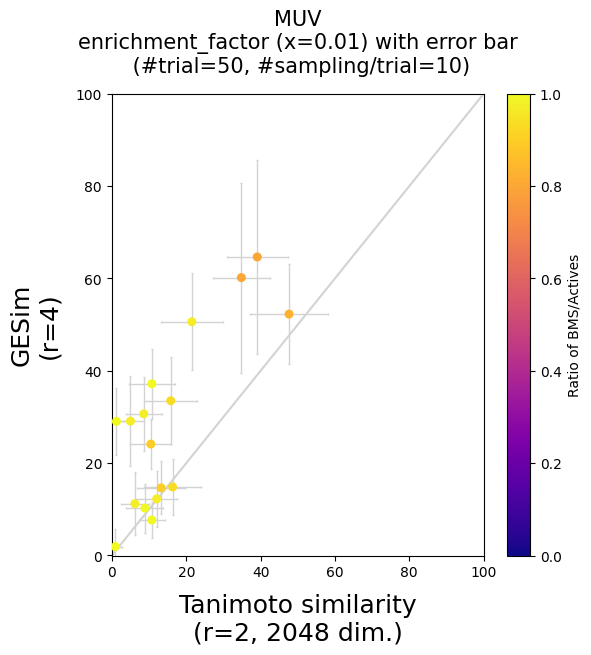

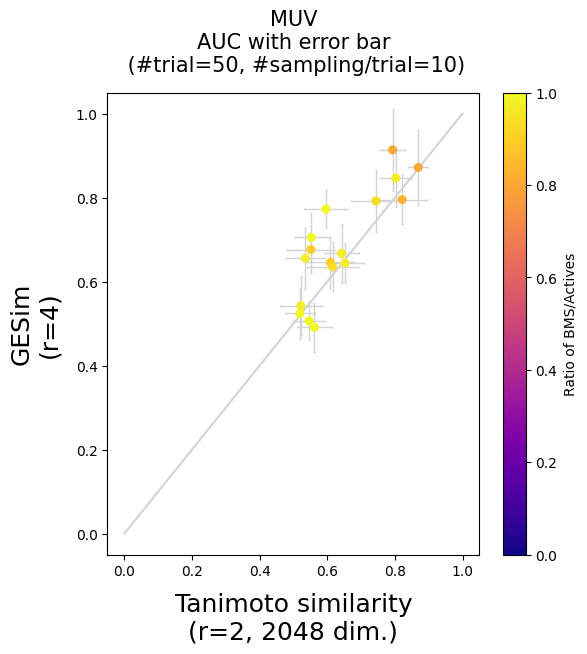

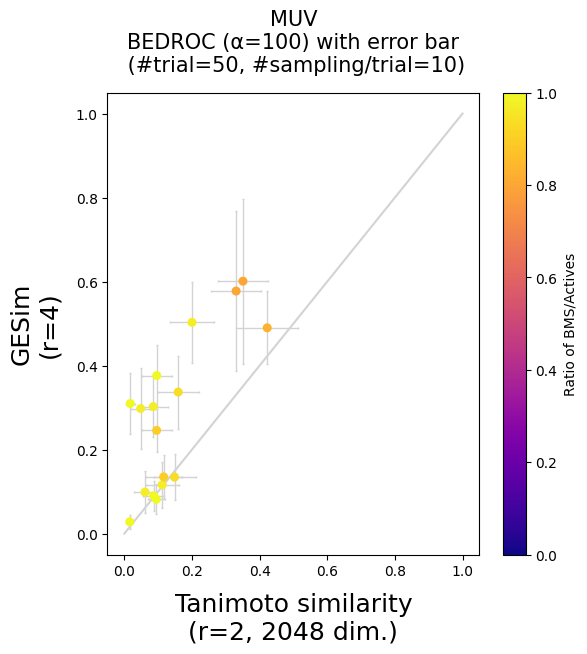

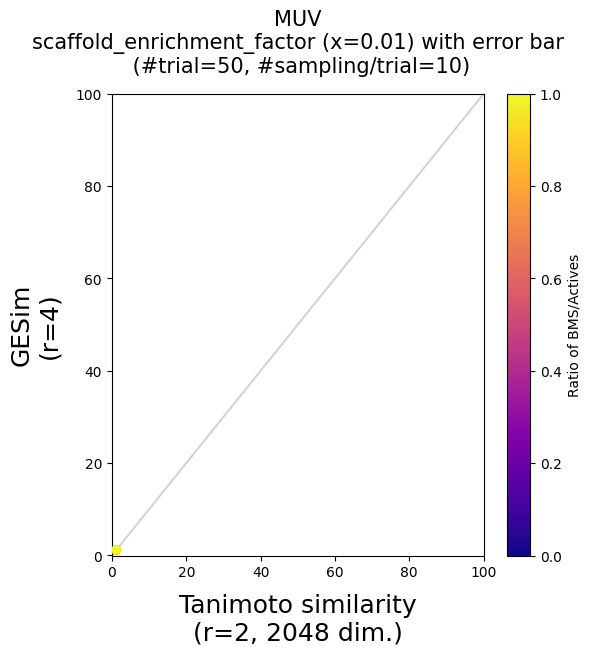

In [137]:
plot_all_methods_performance(tani_a100_f001_stat, ge_r1_a100_f001_stat, 'MUV', target_labels,
                            target_ba_ratio_dict, alpha=100, fraction=0.01, gesim_r=1)
plot_all_methods_performance(tani_a100_f001_stat, ge_r2_a100_f001_stat, 'MUV', target_labels,
                            target_ba_ratio_dict, alpha=100, fraction=0.01, gesim_r=2)
plot_all_methods_performance(tani_a100_f001_stat, ge_r3_a100_f001_stat, 'MUV', target_labels,
                            target_ba_ratio_dict, alpha=100, fraction=0.01, gesim_r=3)
plot_all_methods_performance(tani_a100_f001_stat, ge_r4_a100_f001_stat, 'MUV', target_labels,
                            target_ba_ratio_dict, alpha=100, fraction=0.01, gesim_r=4)

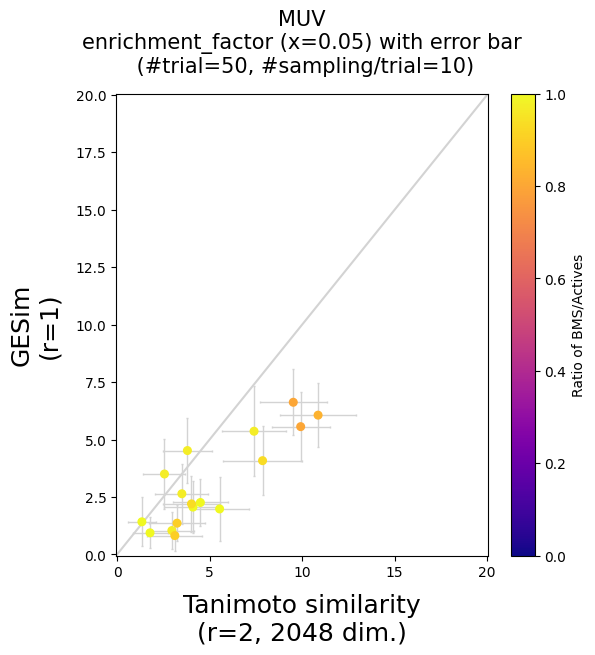

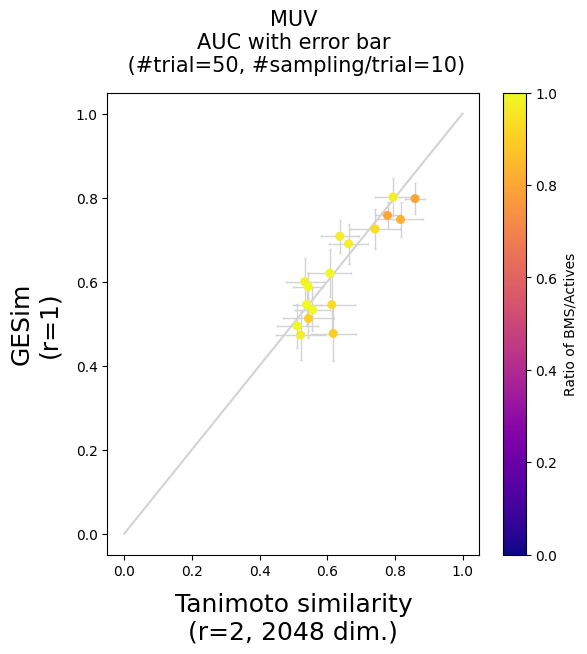

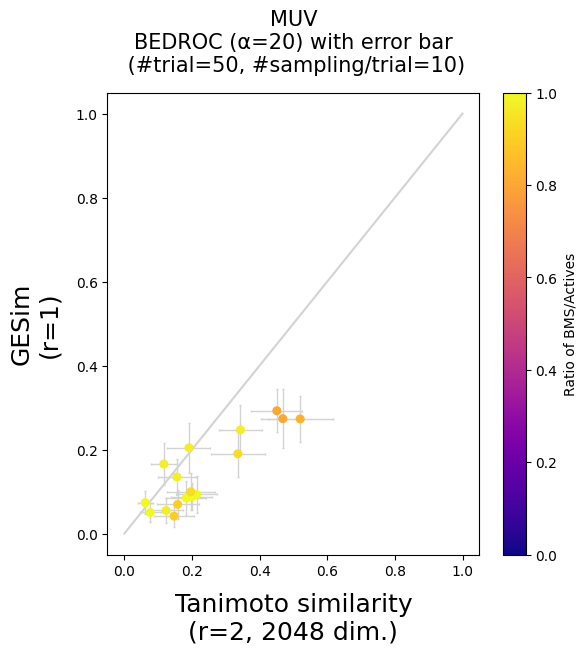

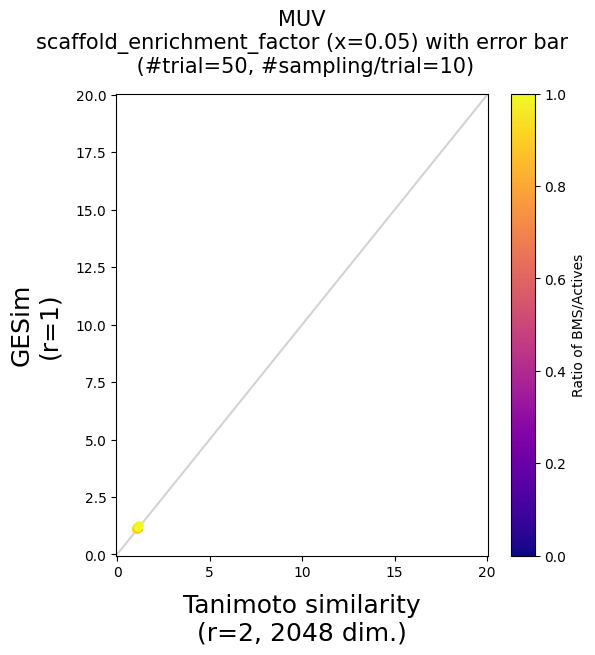

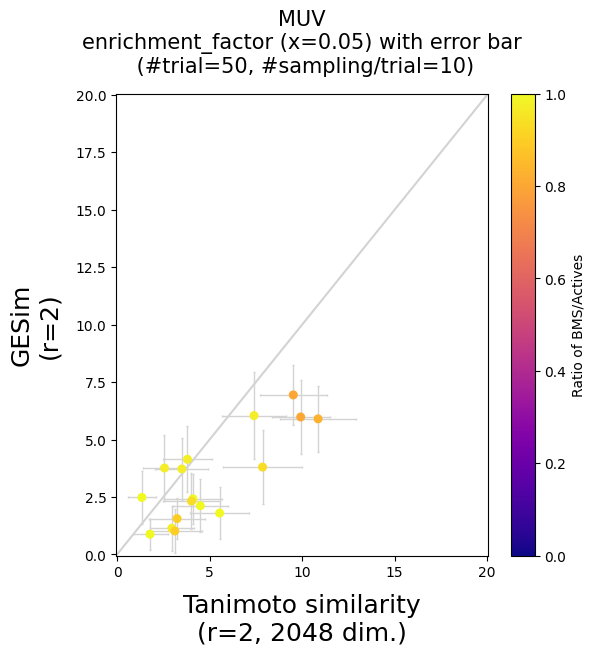

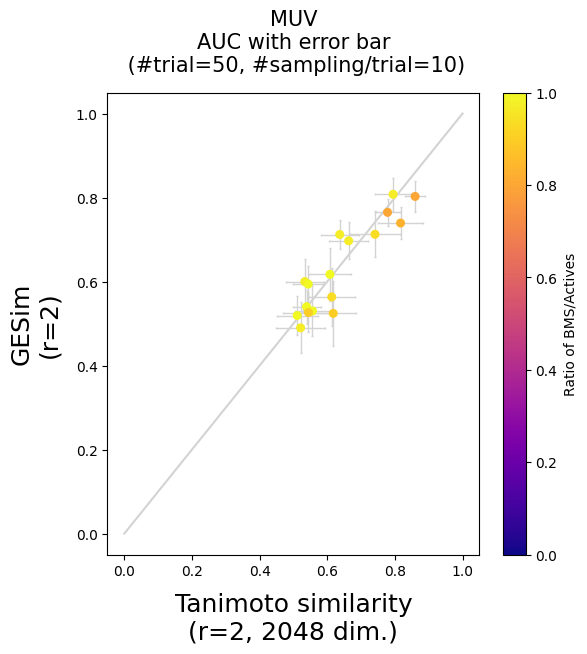

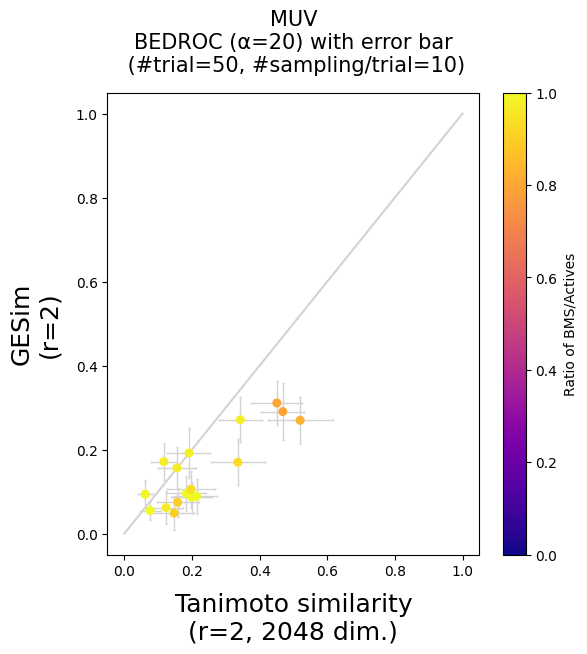

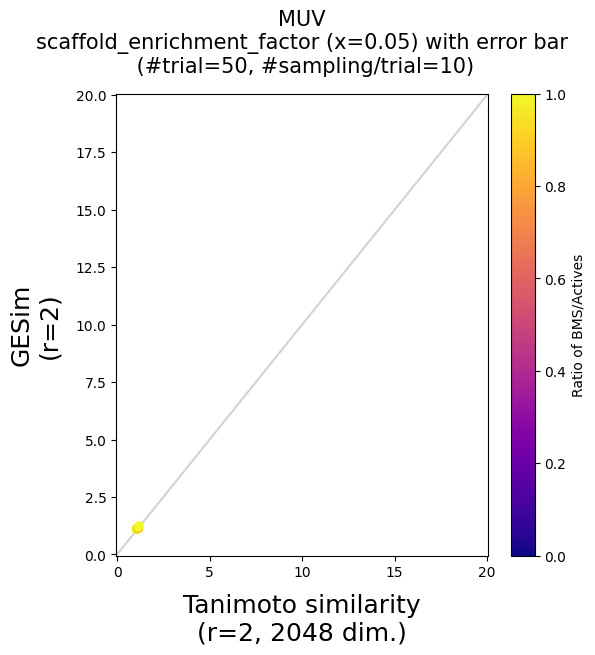

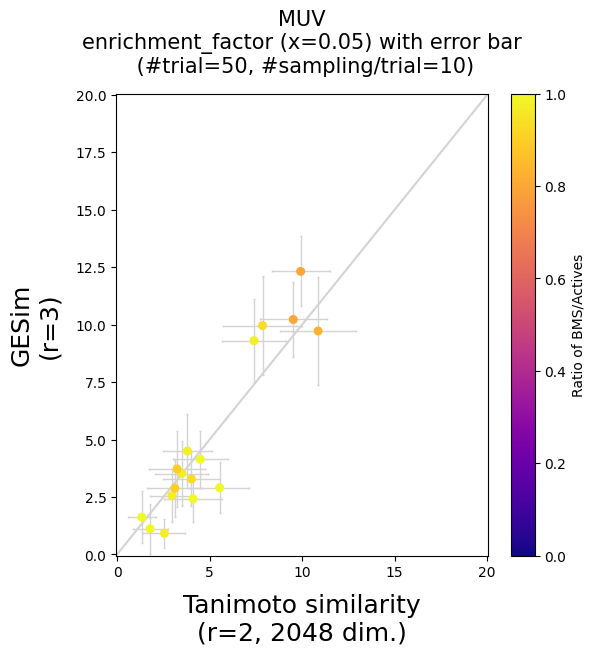

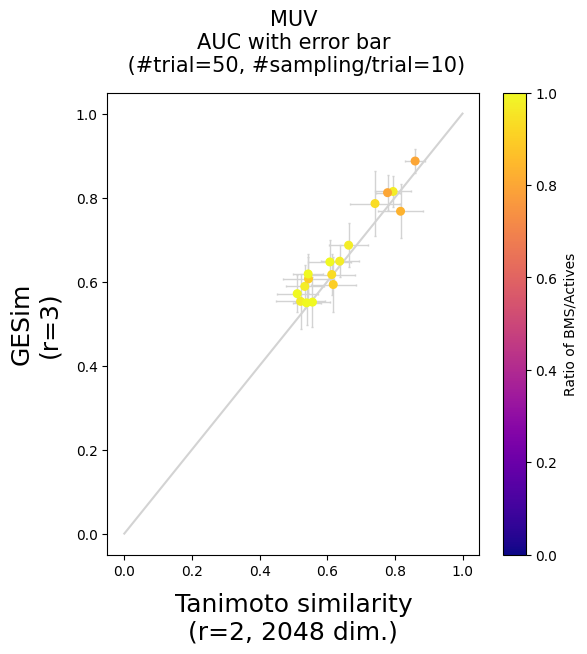

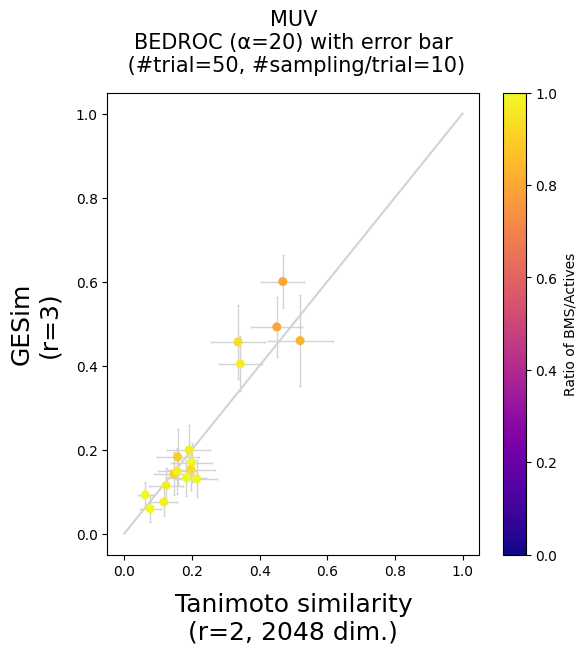

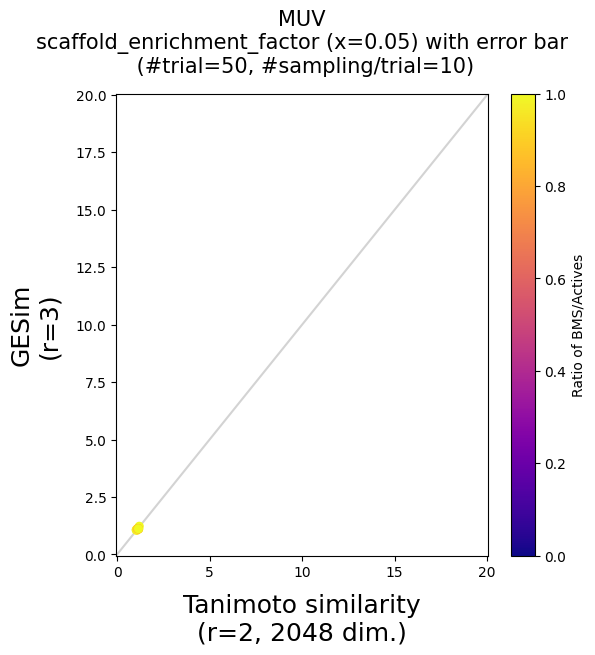

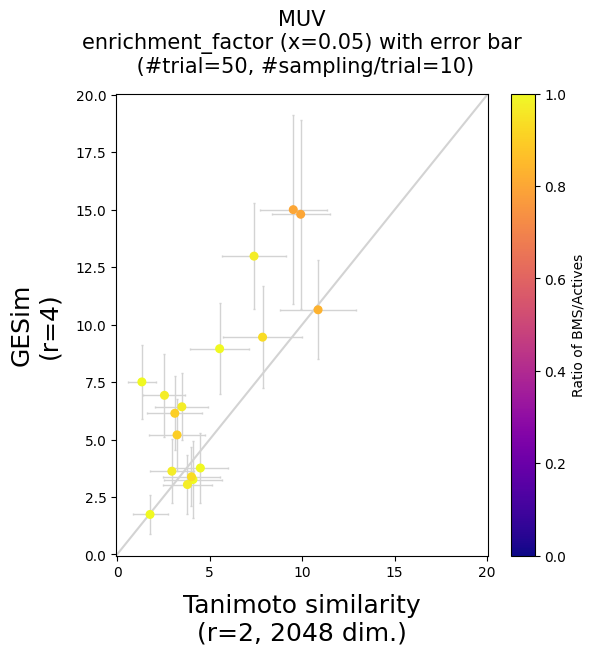

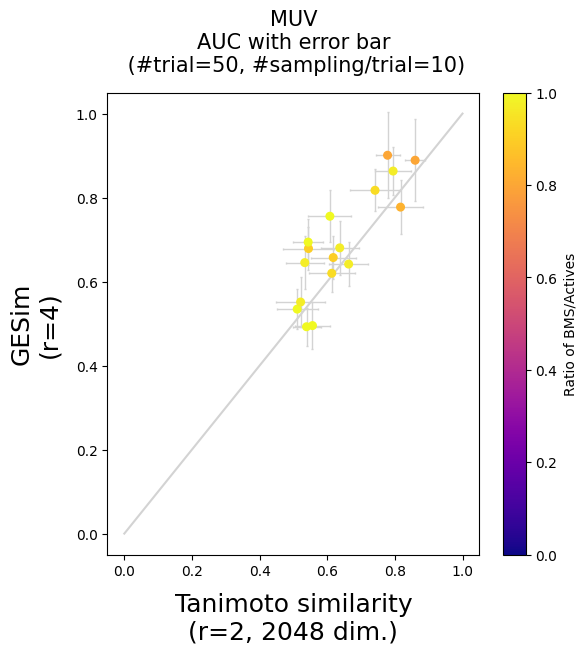

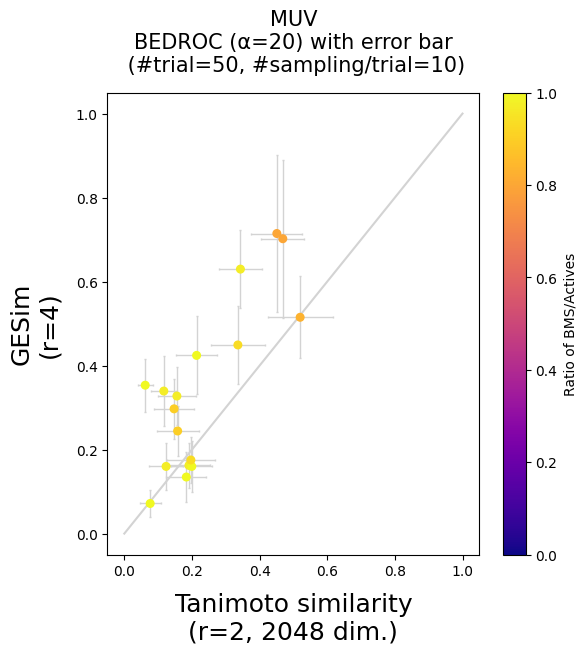

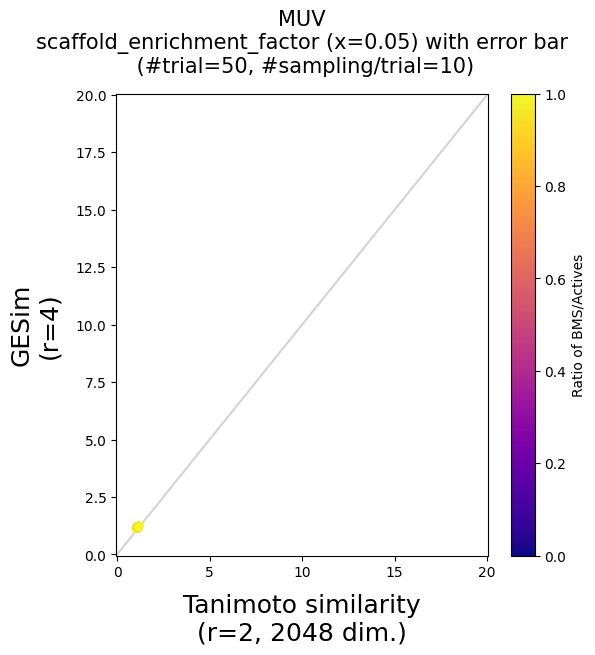

In [138]:
plot_all_methods_performance(tani_a20_f005_stat, ge_r1_a20_f005_stat, 'MUV', target_labels,
                            target_ba_ratio_dict, alpha=20, fraction=0.05, gesim_r=1)
plot_all_methods_performance(tani_a20_f005_stat, ge_r2_a20_f005_stat, 'MUV', target_labels,
                            target_ba_ratio_dict, alpha=20, fraction=0.05, gesim_r=2)
plot_all_methods_performance(tani_a20_f005_stat, ge_r3_a20_f005_stat, 'MUV', target_labels,
                            target_ba_ratio_dict, alpha=20, fraction=0.05, gesim_r=3)
plot_all_methods_performance(tani_a20_f005_stat, ge_r4_a20_f005_stat, 'MUV', target_labels,
                            target_ba_ratio_dict, alpha=20, fraction=0.05, gesim_r=4)

In [139]:
# DUD

import pickle
dataset_root_dir = "./result/benchmarking_platform/DUD/"

with open(f'{dataset_root_dir}/ge_sim/result_r1_a100_f001.pkl', 'rb') as f:
    ge_r1_a100_f001_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r1_a20_f005.pkl', 'rb') as f:
    ge_r1_a20_f005_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r2_a100_f001.pkl', 'rb') as f:
    ge_r2_a100_f001_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r2_a20_f005.pkl', 'rb') as f:
    ge_r2_a20_f005_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r3_a100_f001.pkl', 'rb') as f:
    ge_r3_a100_f001_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r3_a20_f005.pkl', 'rb') as f:
    ge_r3_a20_f005_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r4_a100_f001.pkl', 'rb') as f:
    ge_r4_a100_f001_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r4_a20_f005.pkl', 'rb') as f:
    ge_r4_a20_f005_result = pickle.load(f)

with open(f'{dataset_root_dir}/tanimoto_sim/result_a100_f001.pkl', 'rb') as f:
    tani_a100_f001_result = pickle.load(f)
with open(f'{dataset_root_dir}/tanimoto_sim/result_a20_f005.pkl', 'rb') as f:
    tani_a20_f005_result = pickle.load(f)

target_labels = list(tani_a100_f001_result.keys())

ge_r1_a100_f001_stat = ResultContent()
ge_r1_a20_f005_stat = ResultContent()
ge_r2_a100_f001_stat = ResultContent()
ge_r2_a20_f005_stat = ResultContent()
ge_r3_a100_f001_stat = ResultContent()
ge_r3_a20_f005_stat = ResultContent()
ge_r4_a100_f001_stat = ResultContent()
ge_r4_a20_f005_stat = ResultContent()

tani_a100_f001_stat = ResultContent()
tani_a20_f005_stat = ResultContent()

calculate_stat(ge_r1_a100_f001_result, target_labels, ge_r1_a100_f001_stat.result_stat)
calculate_stat(ge_r1_a20_f005_result, target_labels, ge_r1_a20_f005_stat.result_stat)
calculate_stat(ge_r2_a100_f001_result, target_labels, ge_r2_a100_f001_stat.result_stat)
calculate_stat(ge_r2_a20_f005_result, target_labels, ge_r2_a20_f005_stat.result_stat)
calculate_stat(ge_r3_a100_f001_result, target_labels, ge_r3_a100_f001_stat.result_stat)
calculate_stat(ge_r3_a20_f005_result, target_labels, ge_r3_a20_f005_stat.result_stat)
calculate_stat(ge_r4_a100_f001_result, target_labels, ge_r4_a100_f001_stat.result_stat)
calculate_stat(ge_r4_a20_f005_result, target_labels, ge_r4_a20_f005_stat.result_stat)
calculate_stat(tani_a100_f001_result, target_labels, tani_a100_f001_stat.result_stat)
calculate_stat(tani_a20_f005_result, target_labels, tani_a20_f005_stat.result_stat)

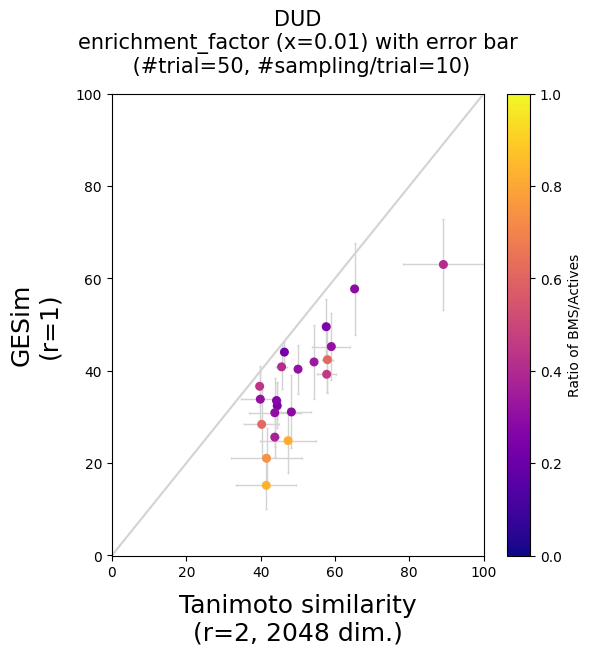

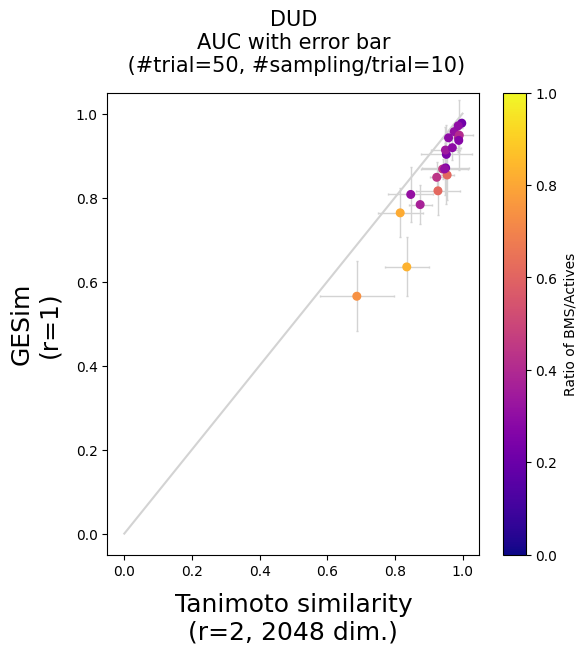

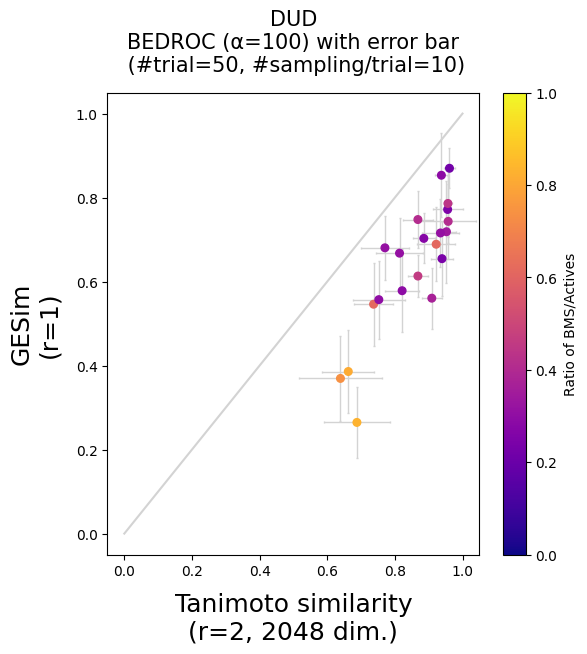

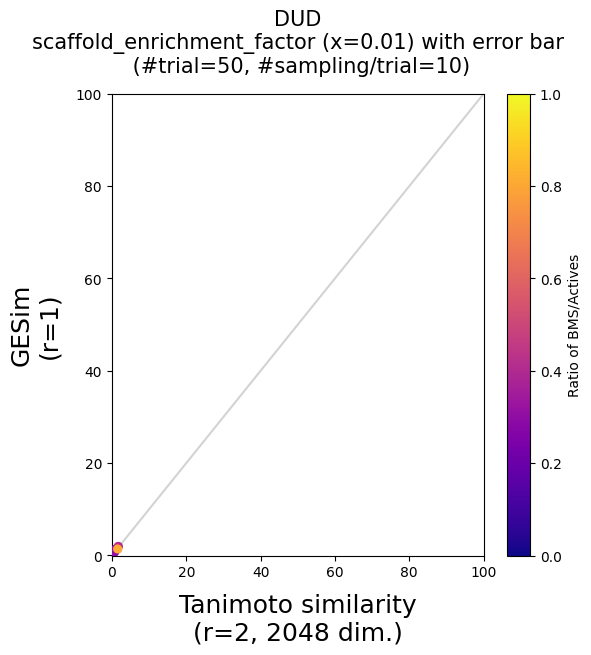

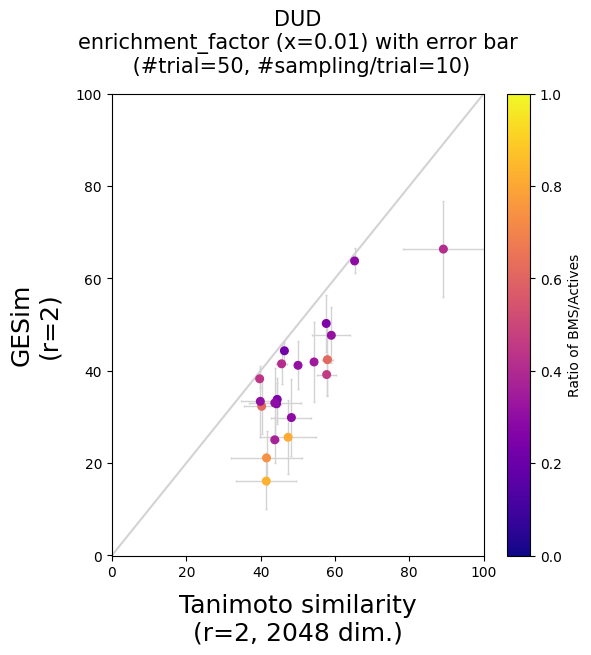

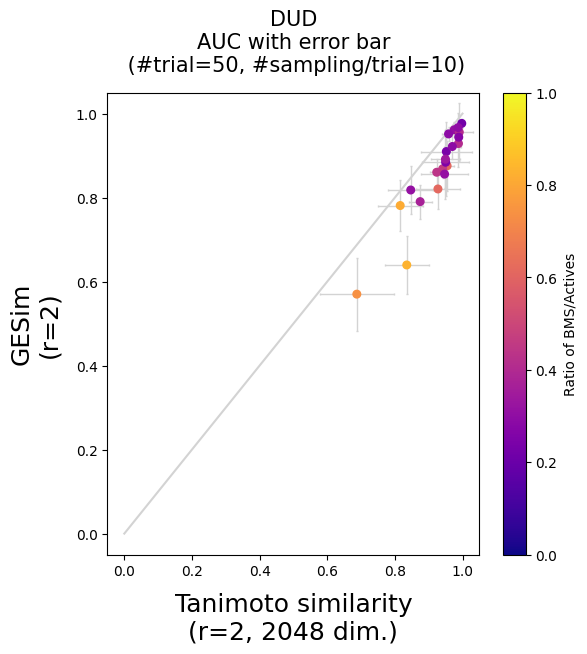

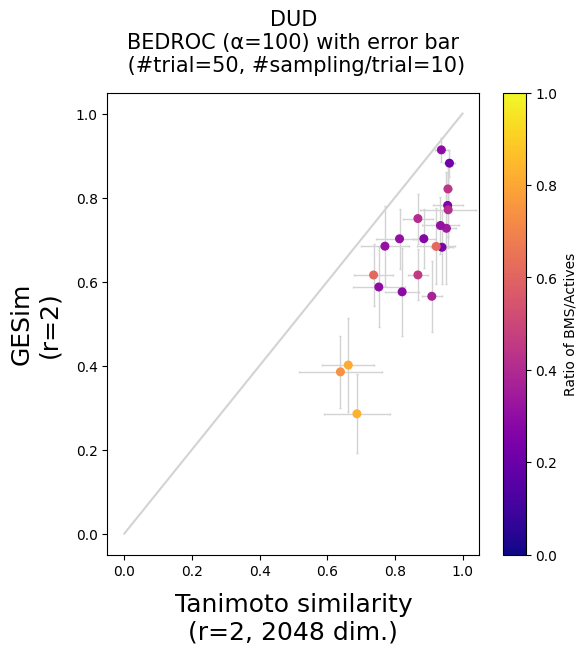

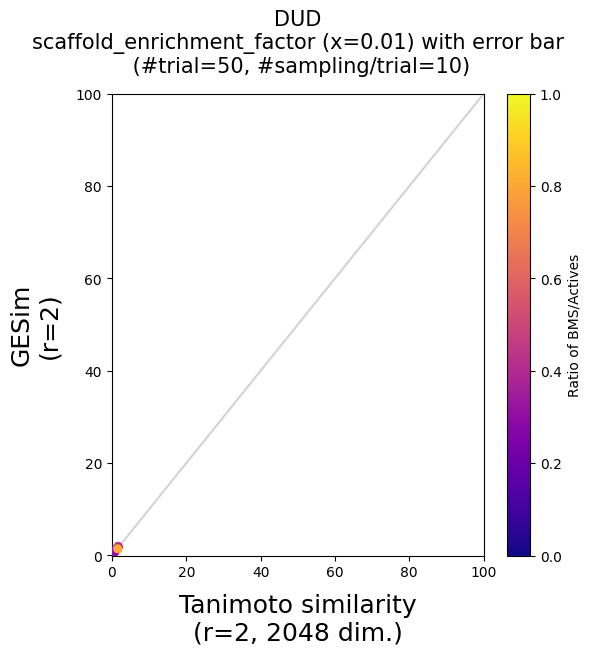

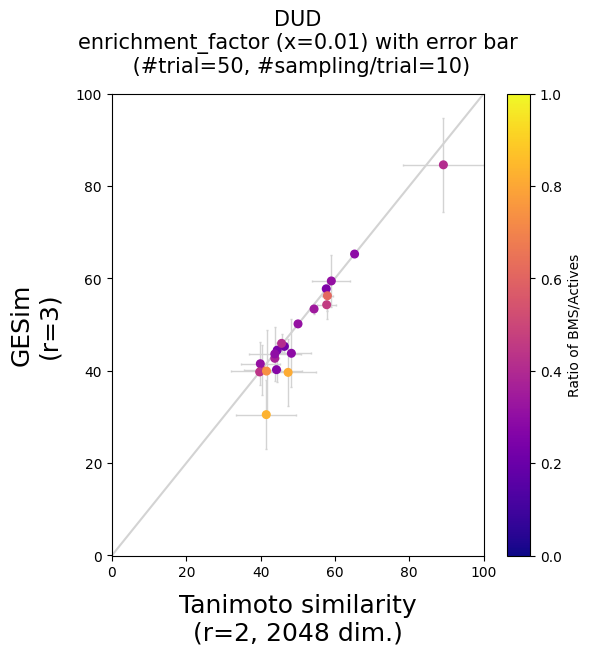

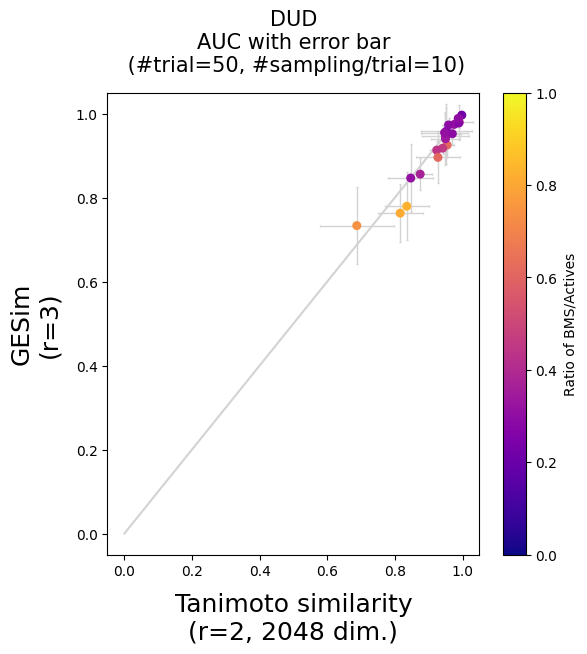

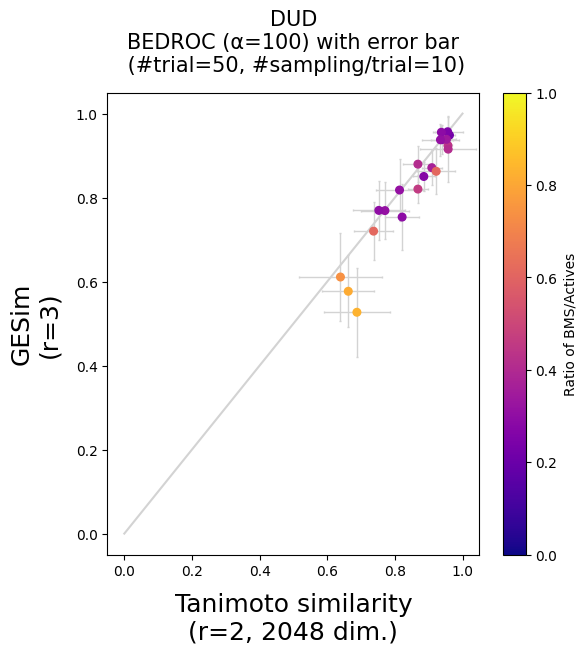

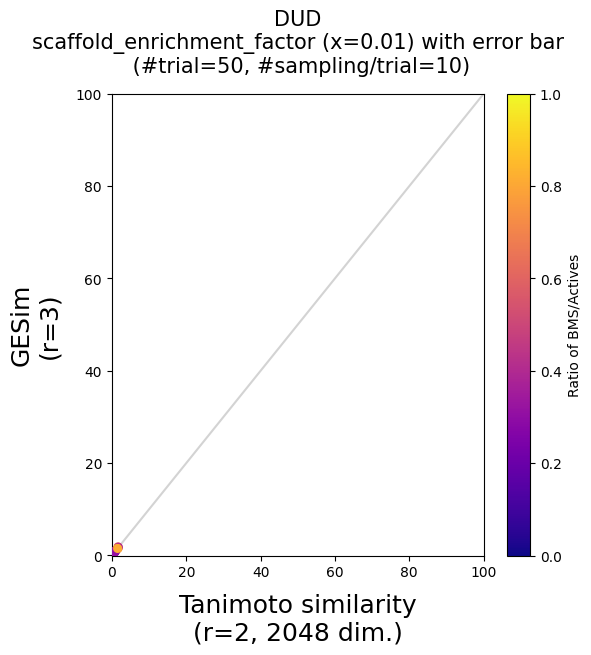

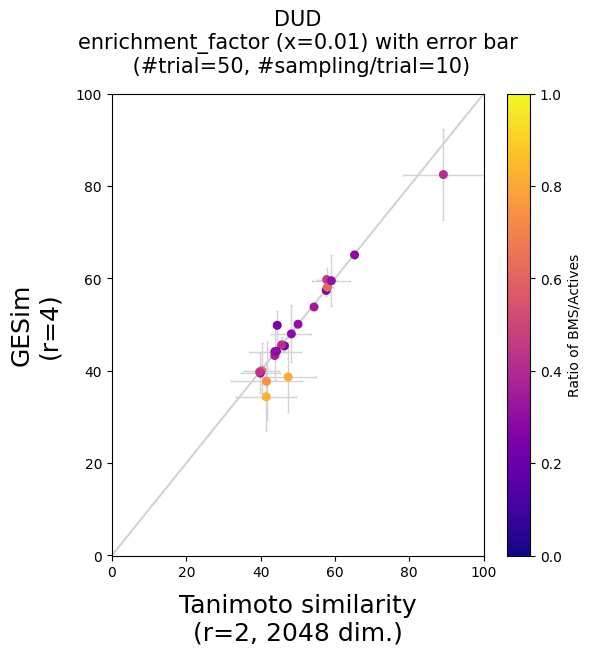

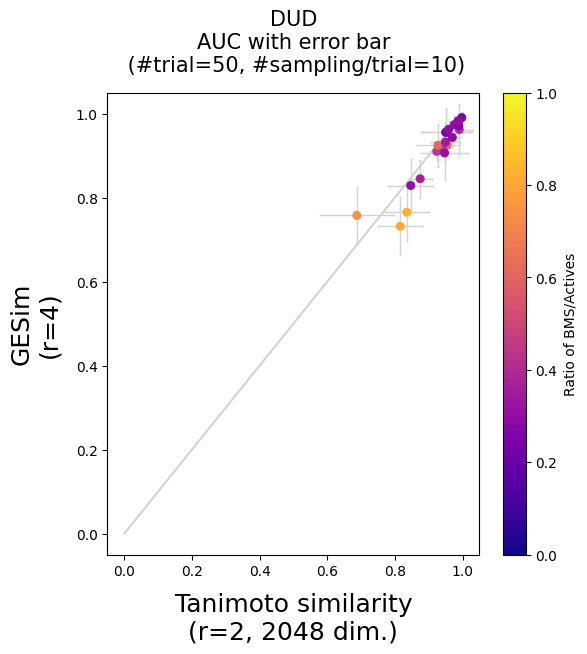

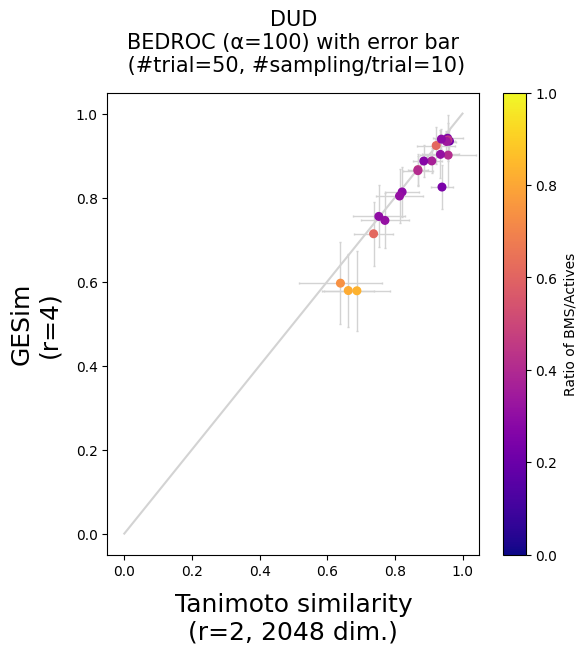

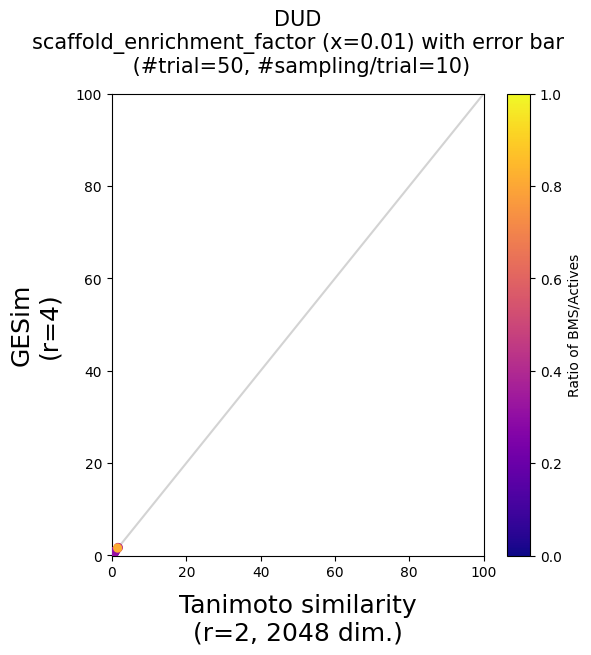

In [141]:
plot_all_methods_performance(tani_a100_f001_stat, ge_r1_a100_f001_stat, 'DUD', target_labels,
                            target_ba_ratio_dict, alpha=100, fraction=0.01, gesim_r=1)
plot_all_methods_performance(tani_a100_f001_stat, ge_r2_a100_f001_stat, 'DUD', target_labels,
                            target_ba_ratio_dict, alpha=100, fraction=0.01, gesim_r=2)
plot_all_methods_performance(tani_a100_f001_stat, ge_r3_a100_f001_stat, 'DUD', target_labels,
                            target_ba_ratio_dict, alpha=100, fraction=0.01, gesim_r=3)
plot_all_methods_performance(tani_a100_f001_stat, ge_r4_a100_f001_stat, 'DUD', target_labels,
                            target_ba_ratio_dict, alpha=100, fraction=0.01, gesim_r=4)

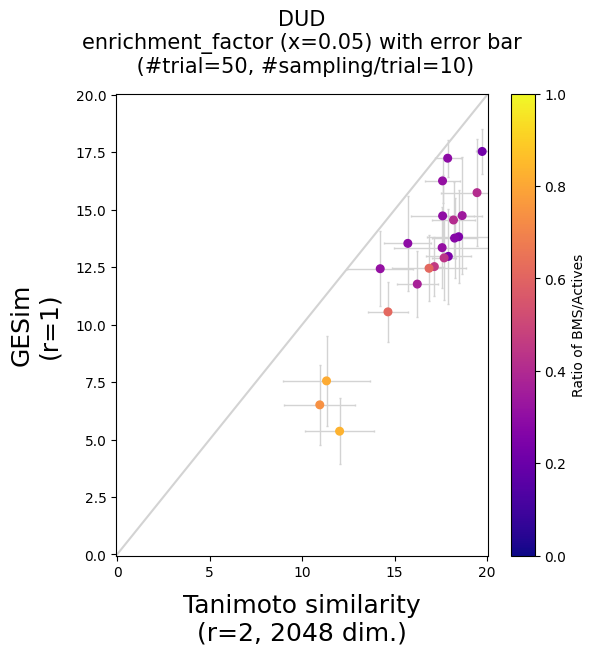

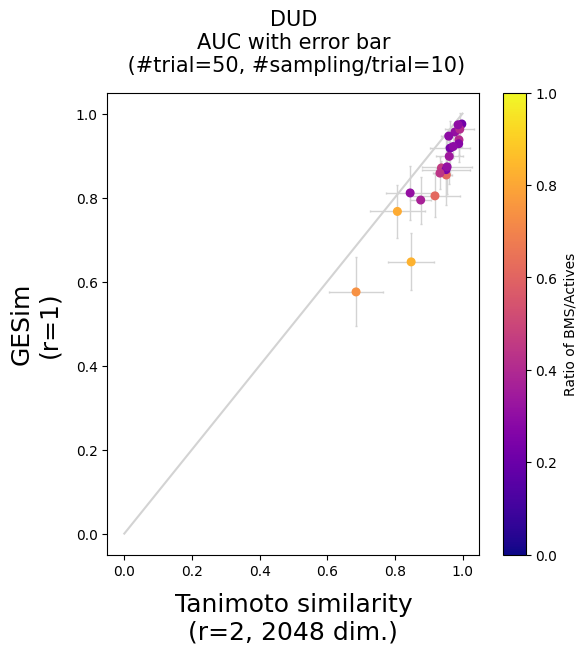

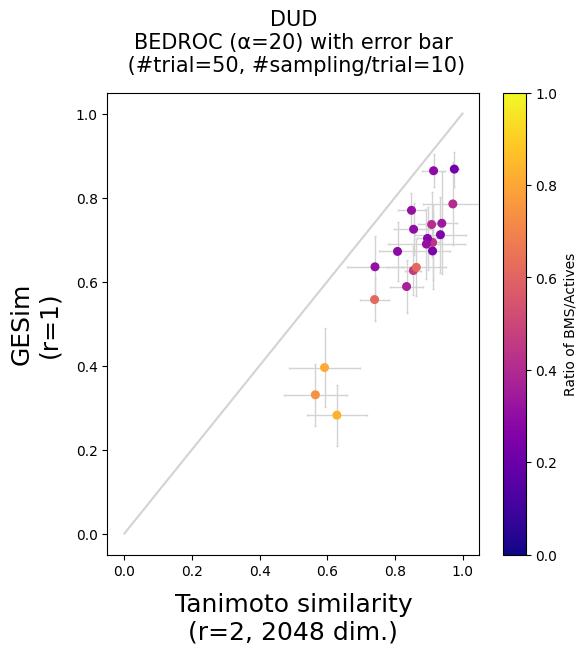

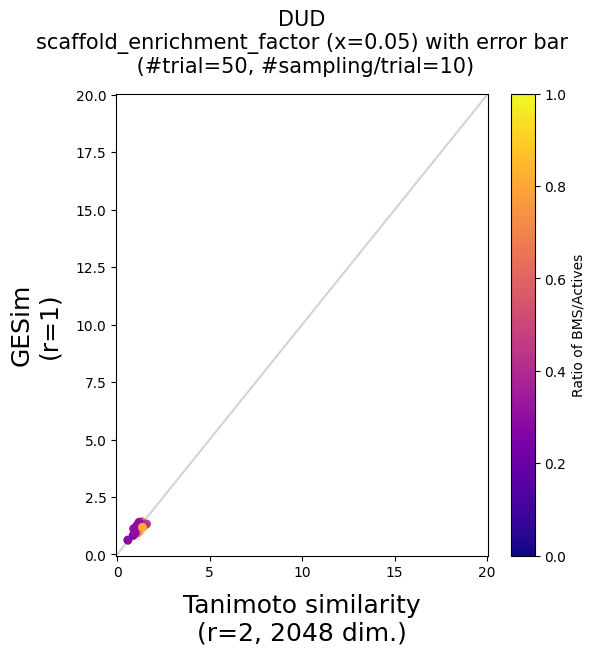

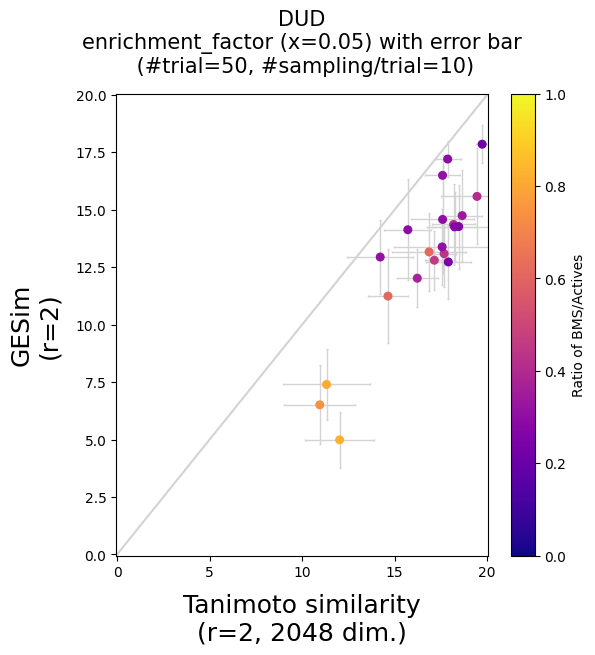

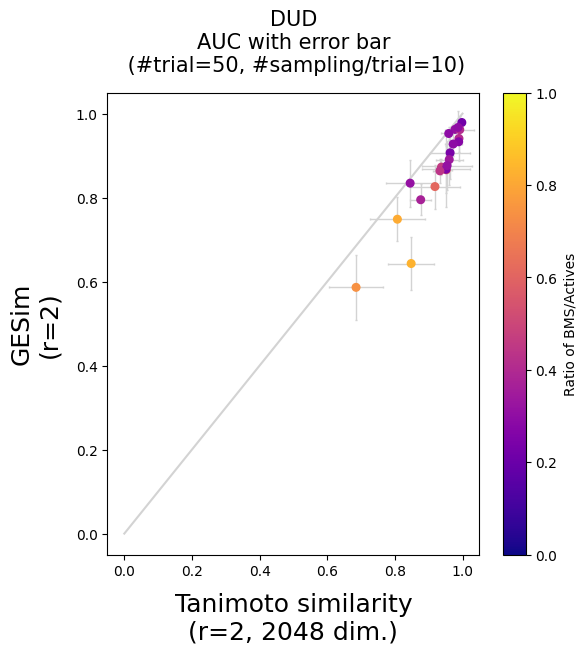

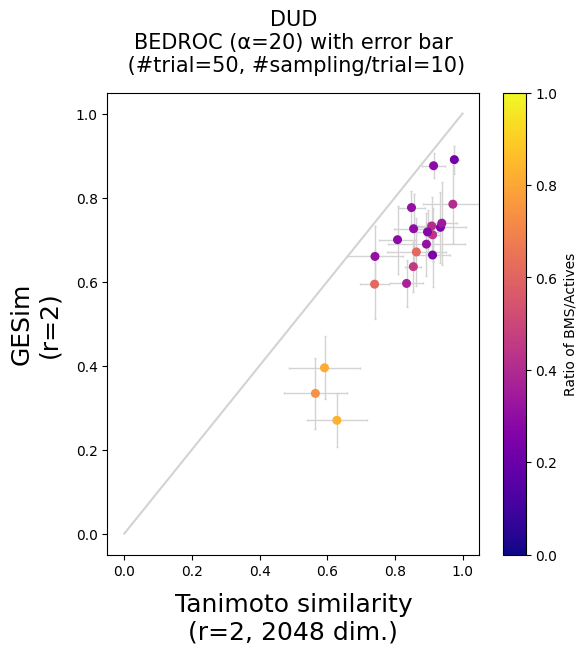

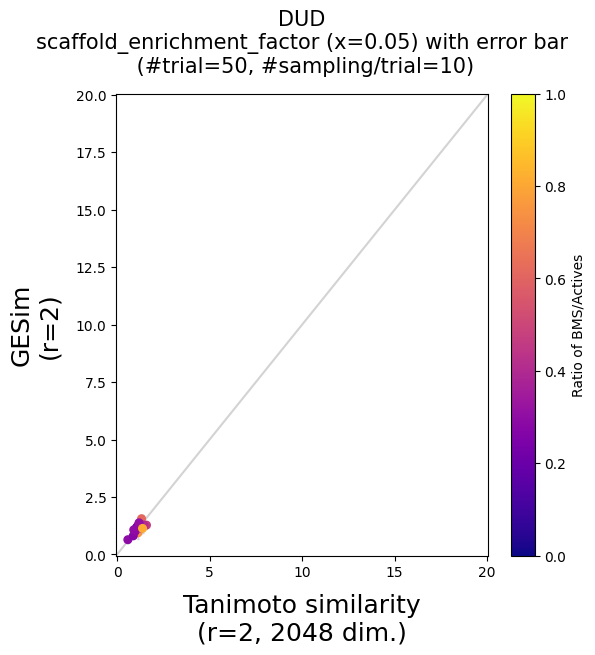

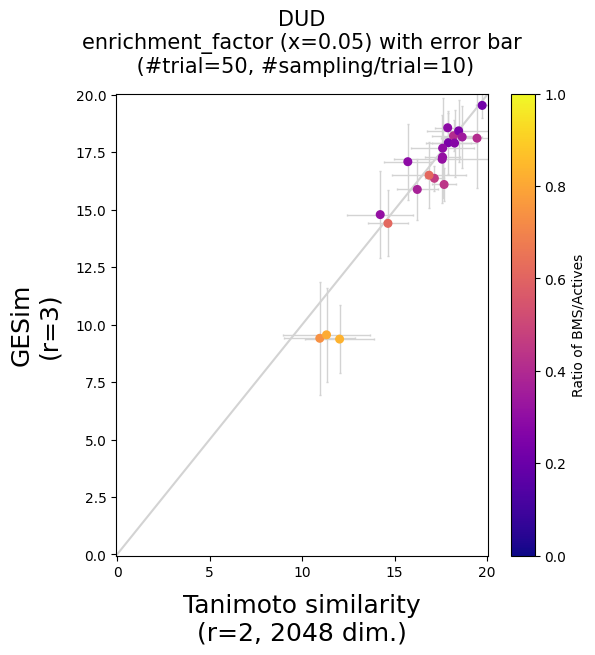

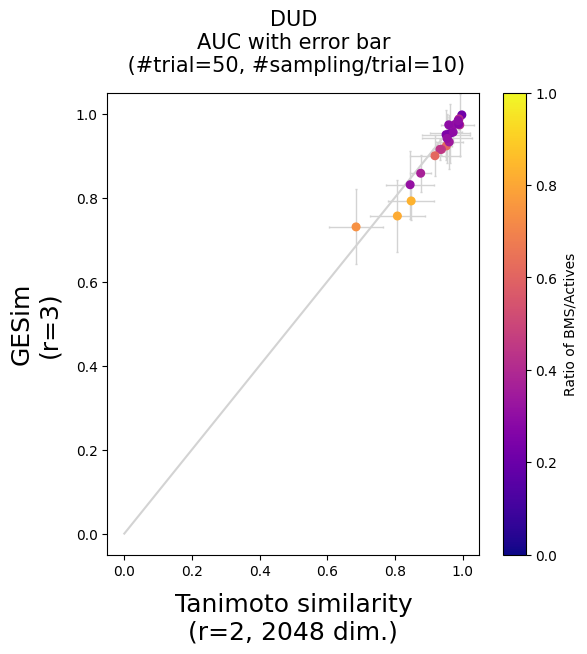

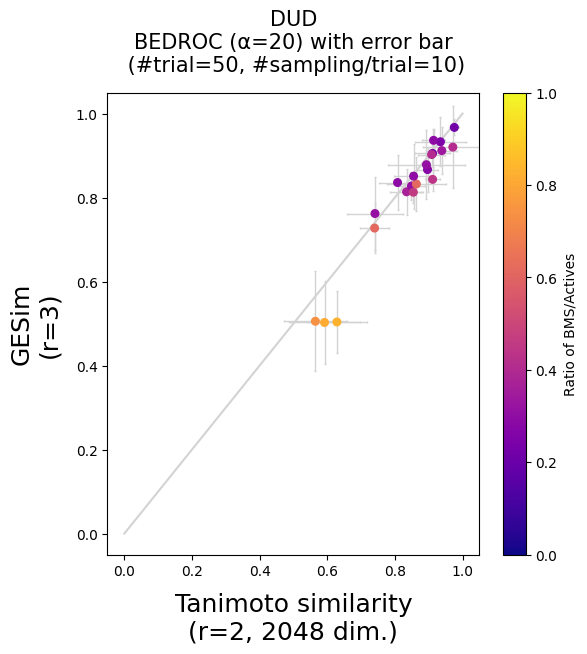

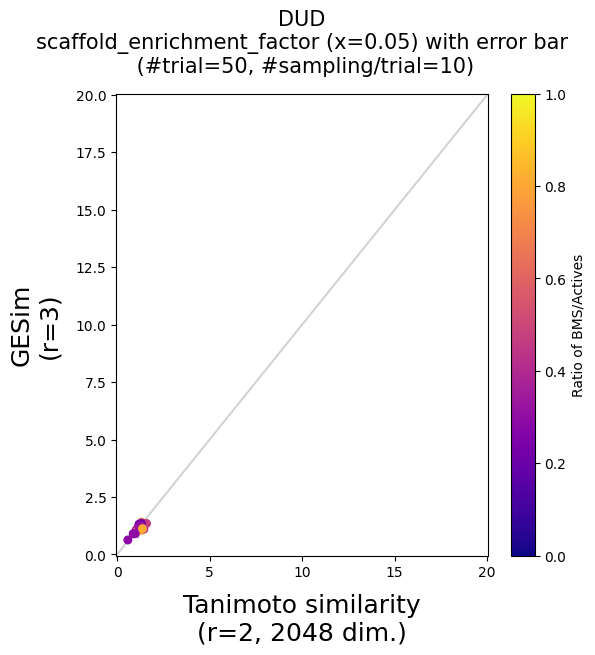

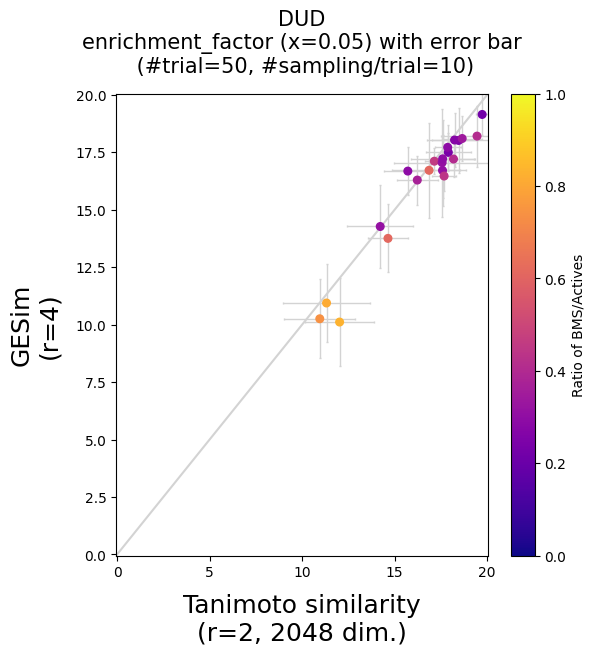

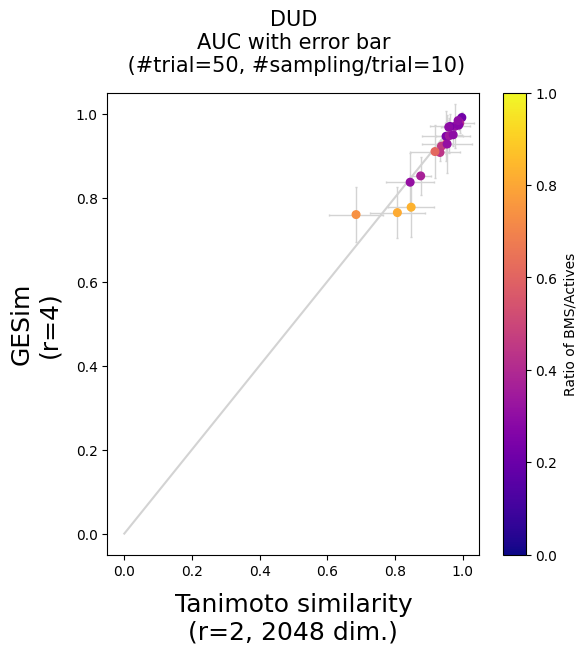

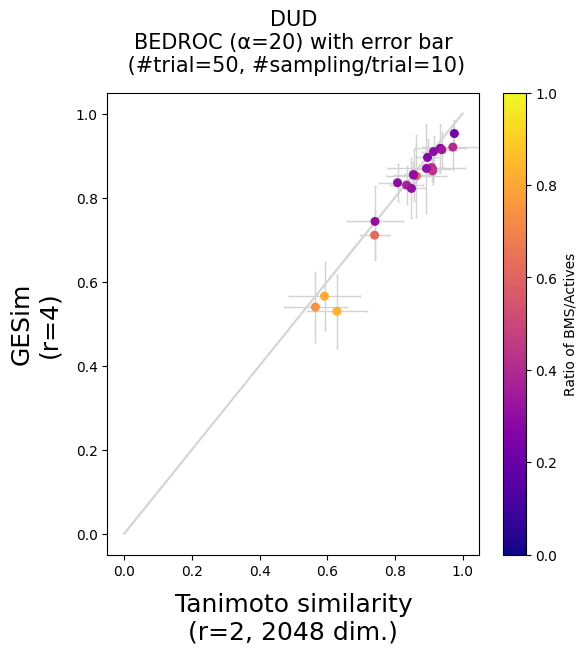

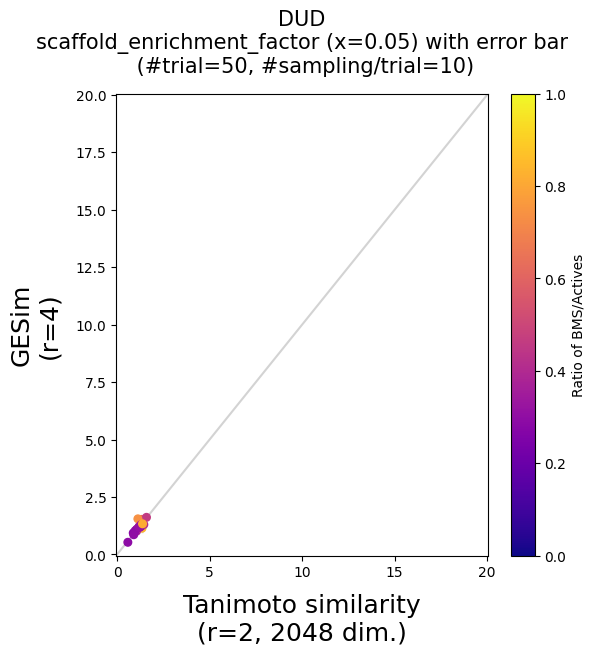

In [142]:
plot_all_methods_performance(tani_a20_f005_stat, ge_r1_a20_f005_stat, 'DUD', target_labels,
                            target_ba_ratio_dict, alpha=20, fraction=0.05, gesim_r=1)
plot_all_methods_performance(tani_a20_f005_stat, ge_r2_a20_f005_stat, 'DUD', target_labels,
                            target_ba_ratio_dict, alpha=20, fraction=0.05, gesim_r=2)
plot_all_methods_performance(tani_a20_f005_stat, ge_r3_a20_f005_stat, 'DUD', target_labels,
                            target_ba_ratio_dict, alpha=20, fraction=0.05, gesim_r=3)
plot_all_methods_performance(tani_a20_f005_stat, ge_r4_a20_f005_stat, 'DUD', target_labels,
                            target_ba_ratio_dict, alpha=20, fraction=0.05, gesim_r=4)

# ChEMBL

In [143]:
import pickle
dataset_root_dir = "./result/benchmarking_platform/ChEMBL/"

with open(f'{dataset_root_dir}/ge_sim/result_r1_a100_f001.pkl', 'rb') as f:
    ge_r1_a100_f001_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r1_a20_f005.pkl', 'rb') as f:
    ge_r1_a20_f005_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r2_a100_f001.pkl', 'rb') as f:
    ge_r2_a100_f001_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r2_a20_f005.pkl', 'rb') as f:
    ge_r2_a20_f005_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r3_a100_f001.pkl', 'rb') as f:
    ge_r3_a100_f001_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r3_a20_f005.pkl', 'rb') as f:
    ge_r3_a20_f005_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r4_a100_f001.pkl', 'rb') as f:
    ge_r4_a100_f001_result = pickle.load(f)
with open(f'{dataset_root_dir}/ge_sim/result_r4_a20_f005.pkl', 'rb') as f:
    ge_r4_a20_f005_result = pickle.load(f)

with open(f'{dataset_root_dir}/tanimoto_sim/result_a100_f001.pkl', 'rb') as f:
    tani_a100_f001_result = pickle.load(f)
with open(f'{dataset_root_dir}/tanimoto_sim/result_a20_f005.pkl', 'rb') as f:
    tani_a20_f005_result = pickle.load(f)

target_labels = list(tani_a100_f001_result.keys())

ge_r1_a100_f001_stat = ResultContent()
ge_r1_a20_f005_stat = ResultContent()
ge_r2_a100_f001_stat = ResultContent()
ge_r2_a20_f005_stat = ResultContent()
ge_r3_a100_f001_stat = ResultContent()
ge_r3_a20_f005_stat = ResultContent()
ge_r4_a100_f001_stat = ResultContent()
ge_r4_a20_f005_stat = ResultContent()

tani_a100_f001_stat = ResultContent()
tani_a20_f005_stat = ResultContent()

calculate_stat(ge_r1_a100_f001_result, target_labels, ge_r1_a100_f001_stat.result_stat)
calculate_stat(ge_r1_a20_f005_result, target_labels, ge_r1_a20_f005_stat.result_stat)
calculate_stat(ge_r2_a100_f001_result, target_labels, ge_r2_a100_f001_stat.result_stat)
calculate_stat(ge_r2_a20_f005_result, target_labels, ge_r2_a20_f005_stat.result_stat)
calculate_stat(ge_r3_a100_f001_result, target_labels, ge_r3_a100_f001_stat.result_stat)
calculate_stat(ge_r3_a20_f005_result, target_labels, ge_r3_a20_f005_stat.result_stat)
calculate_stat(ge_r4_a100_f001_result, target_labels, ge_r4_a100_f001_stat.result_stat)
calculate_stat(ge_r4_a20_f005_result, target_labels, ge_r4_a20_f005_stat.result_stat)
calculate_stat(tani_a100_f001_result, target_labels, tani_a100_f001_stat.result_stat)
calculate_stat(tani_a20_f005_result, target_labels, tani_a20_f005_stat.result_stat)

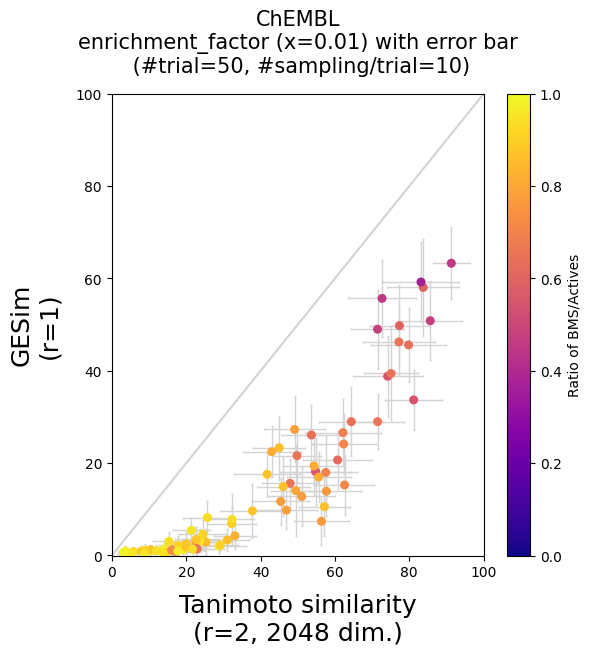

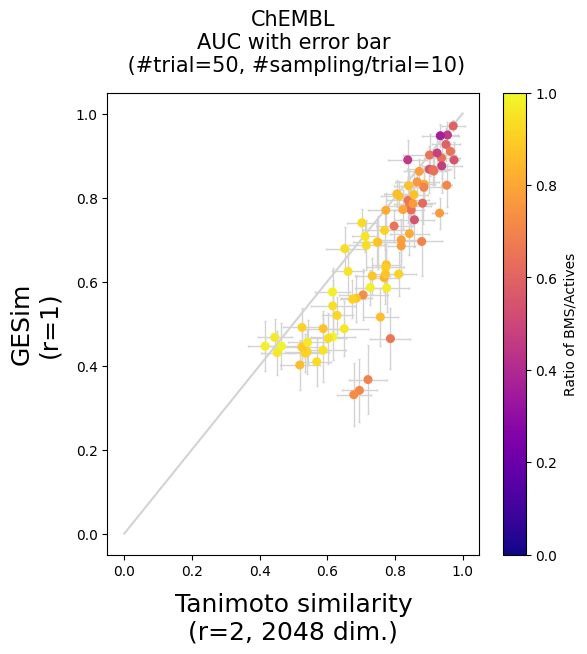

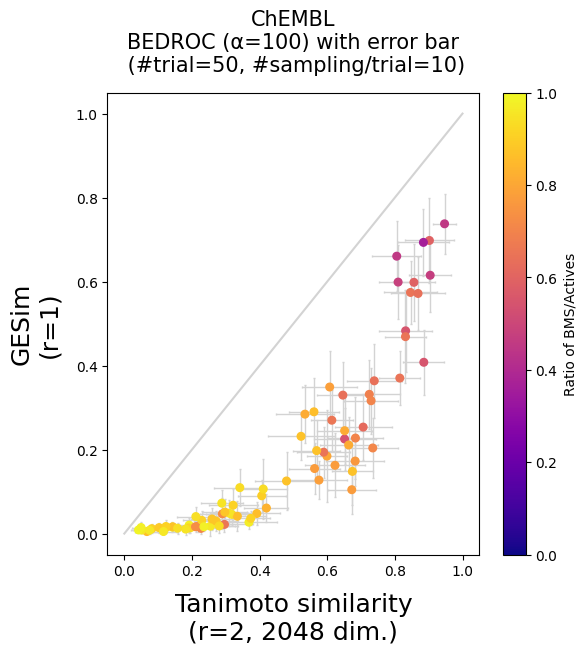

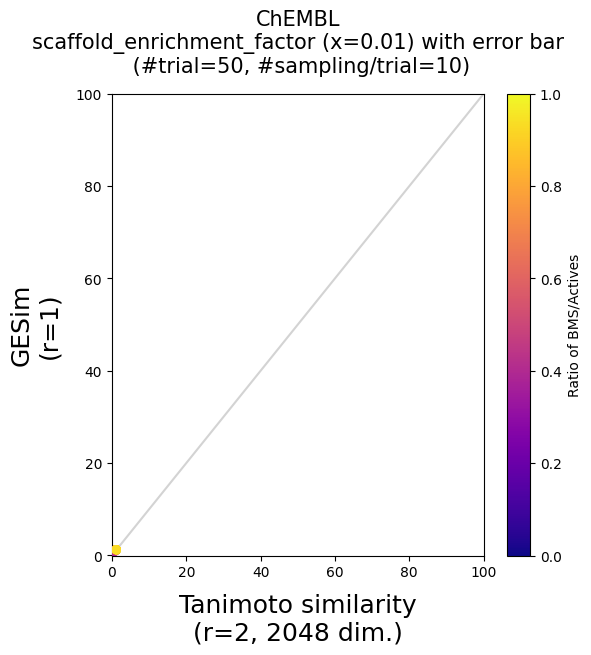

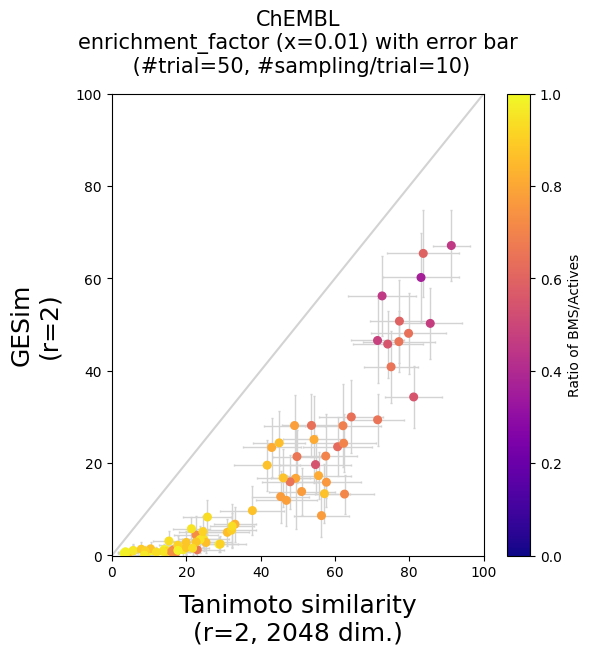

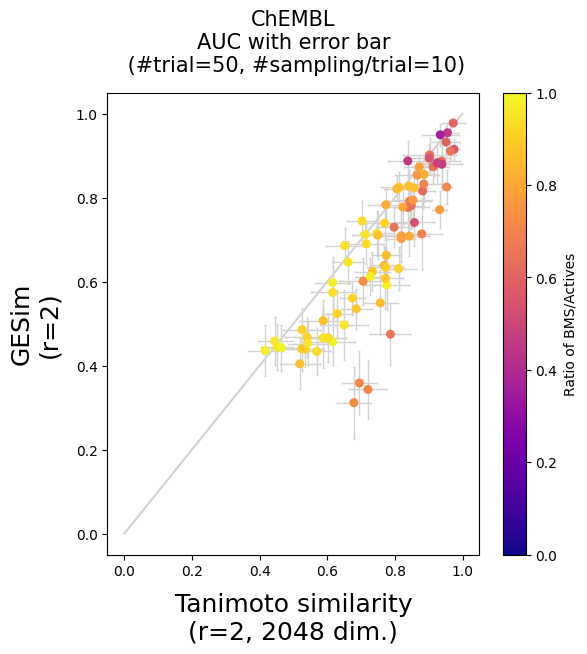

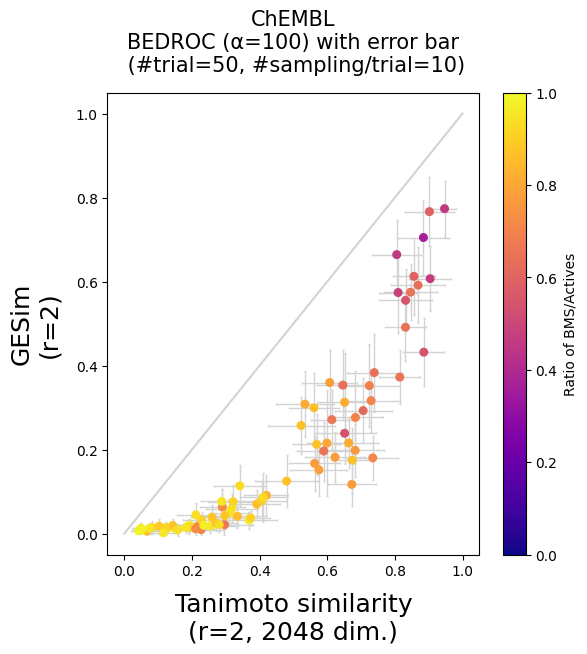

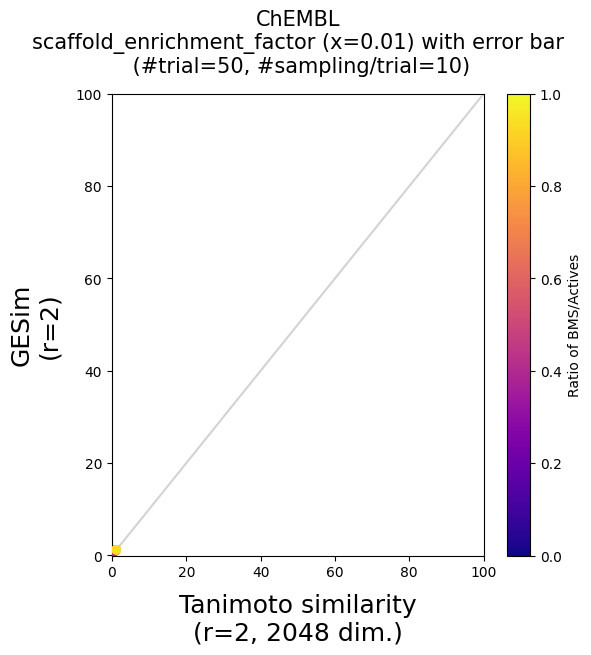

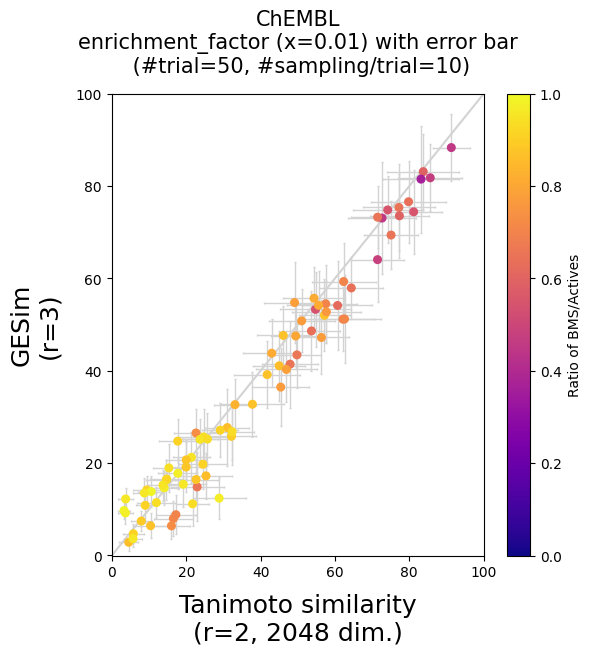

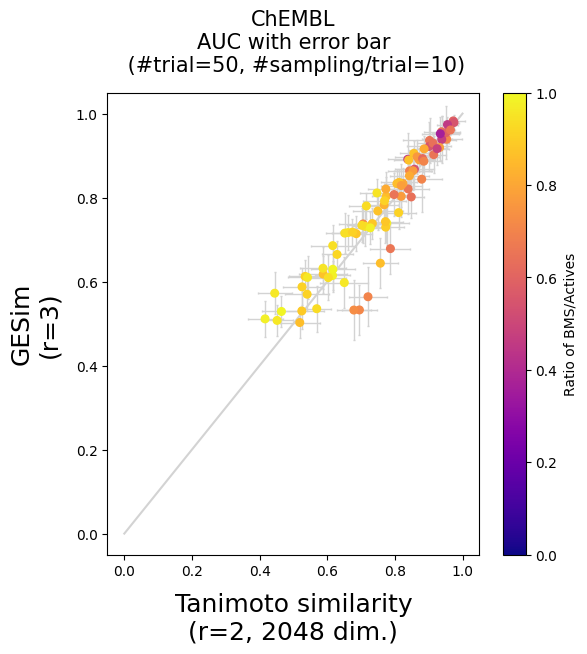

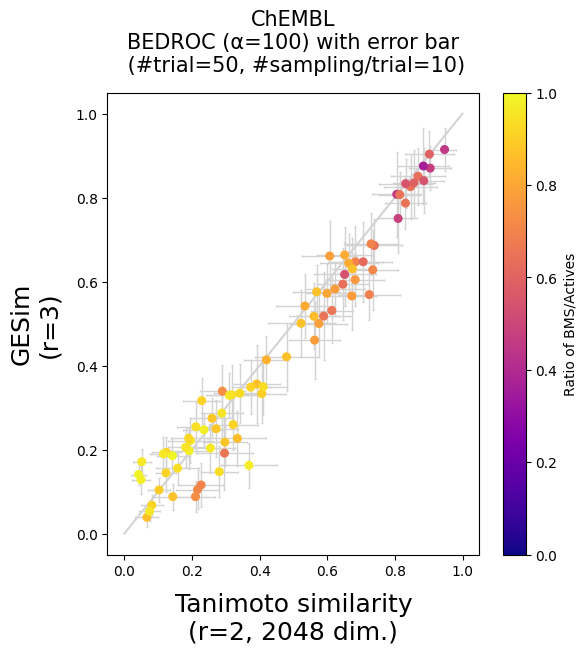

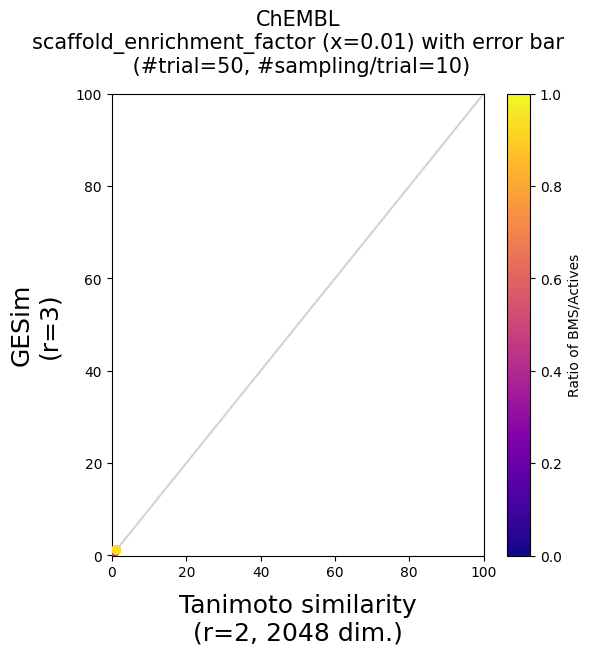

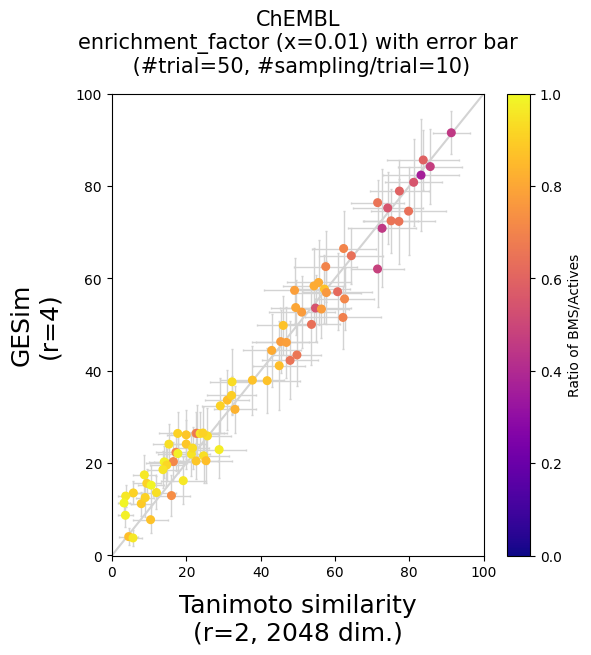

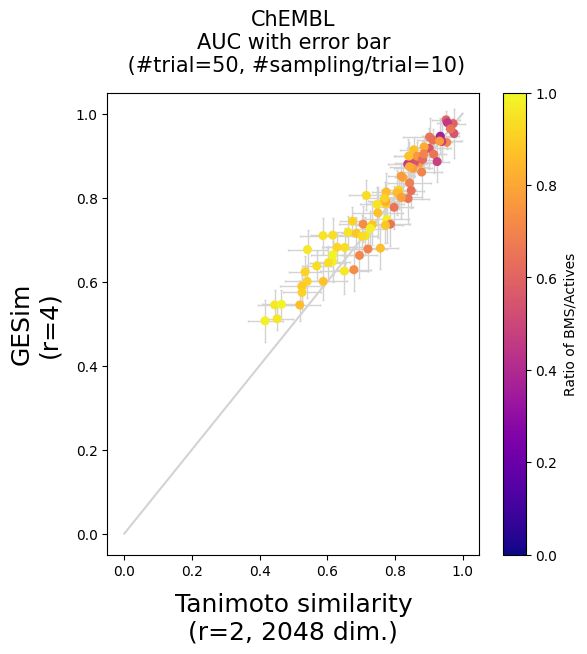

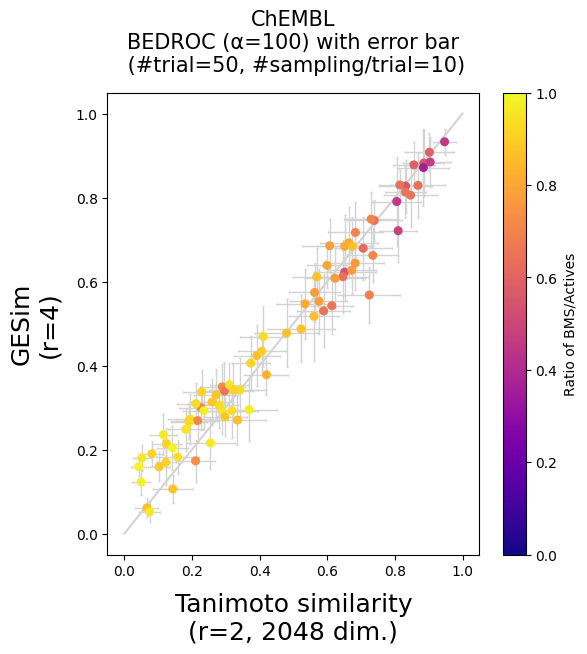

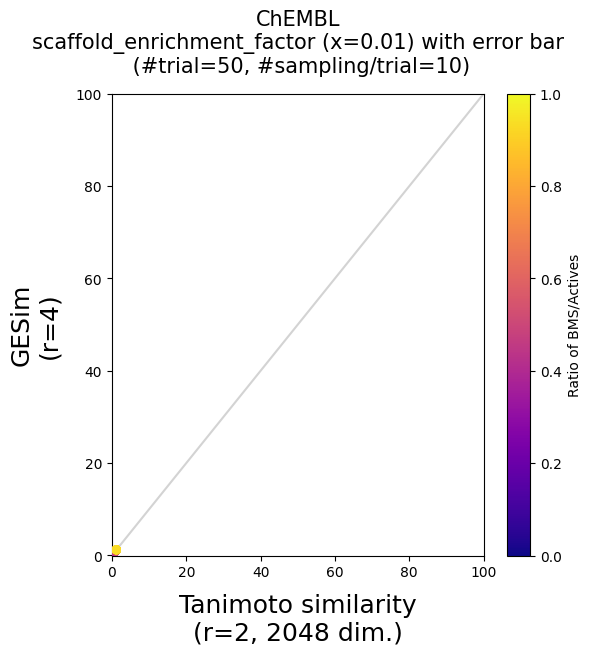

In [144]:
plot_all_methods_performance(tani_a100_f001_stat, ge_r1_a100_f001_stat, 'ChEMBL', target_labels,
                            target_ba_ratio_dict, alpha=100, fraction=0.01, gesim_r=1)
plot_all_methods_performance(tani_a100_f001_stat, ge_r2_a100_f001_stat, 'ChEMBL', target_labels,
                            target_ba_ratio_dict, alpha=100, fraction=0.01, gesim_r=2)
plot_all_methods_performance(tani_a100_f001_stat, ge_r3_a100_f001_stat, 'ChEMBL', target_labels,
                            target_ba_ratio_dict, alpha=100, fraction=0.01, gesim_r=3)
plot_all_methods_performance(tani_a100_f001_stat, ge_r4_a100_f001_stat, 'ChEMBL', target_labels,
                            target_ba_ratio_dict, alpha=100, fraction=0.01, gesim_r=4)

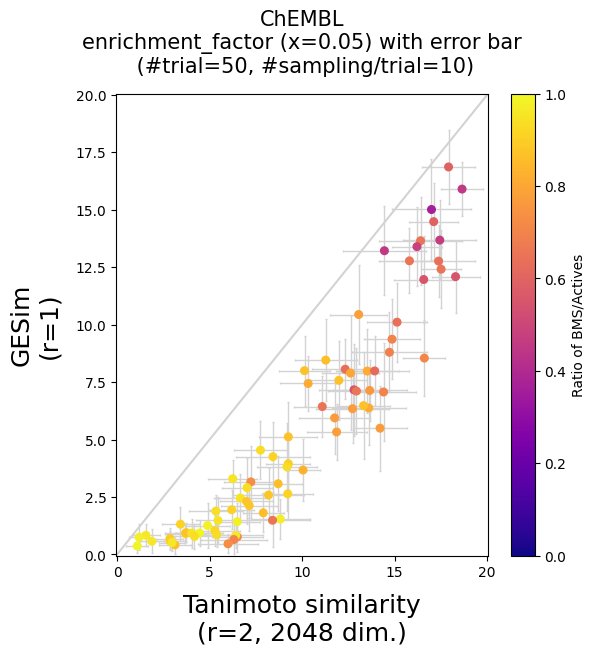

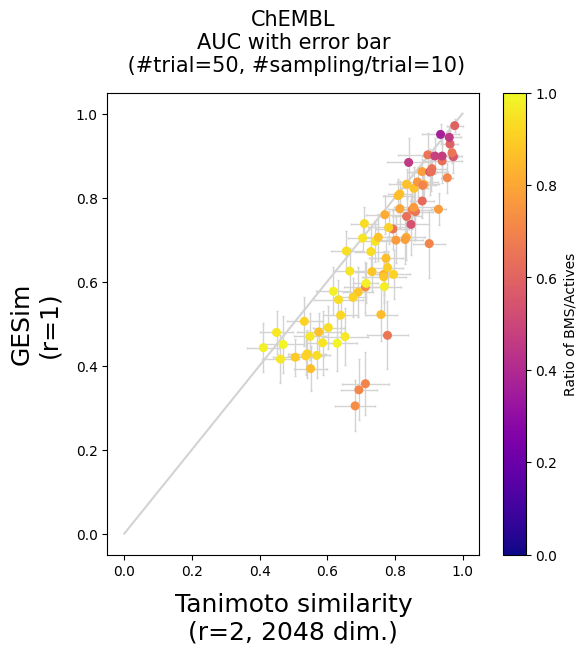

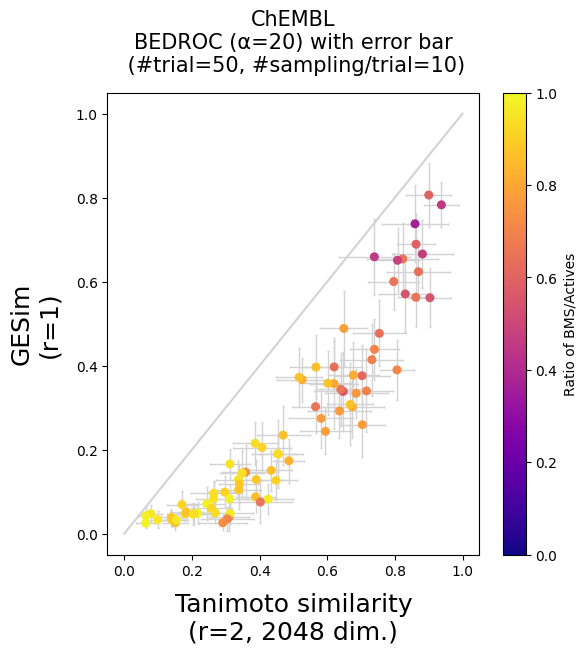

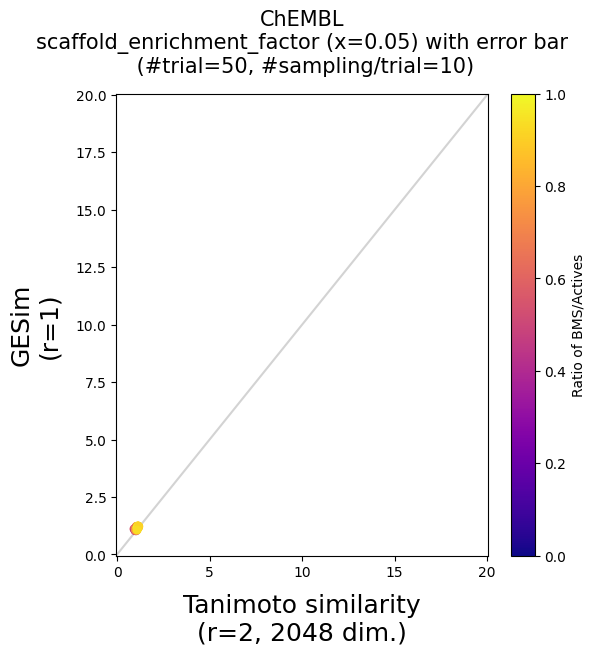

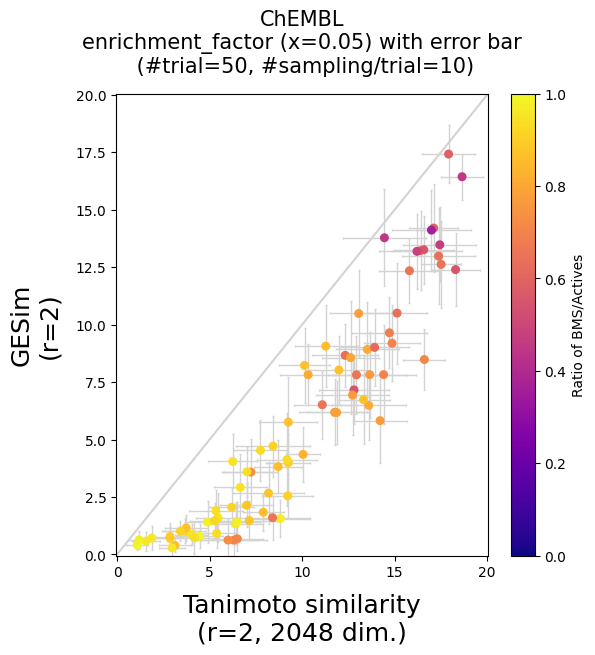

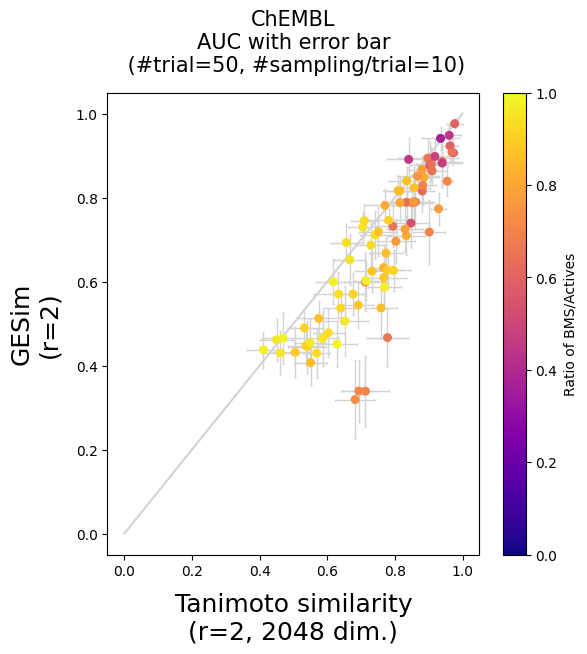

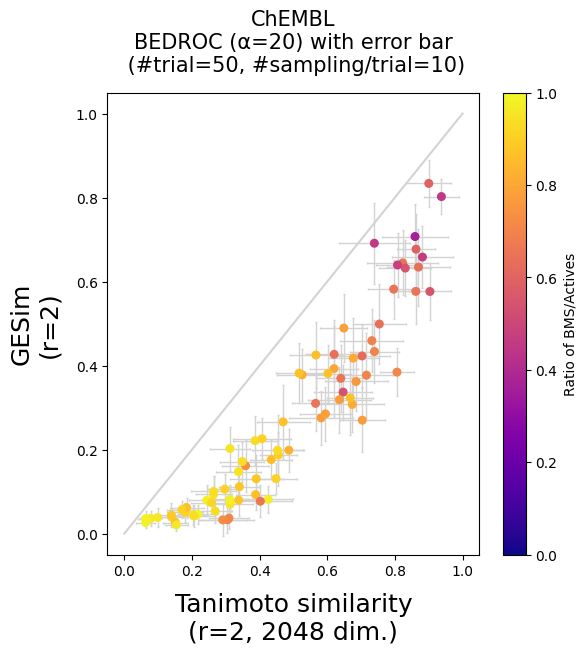

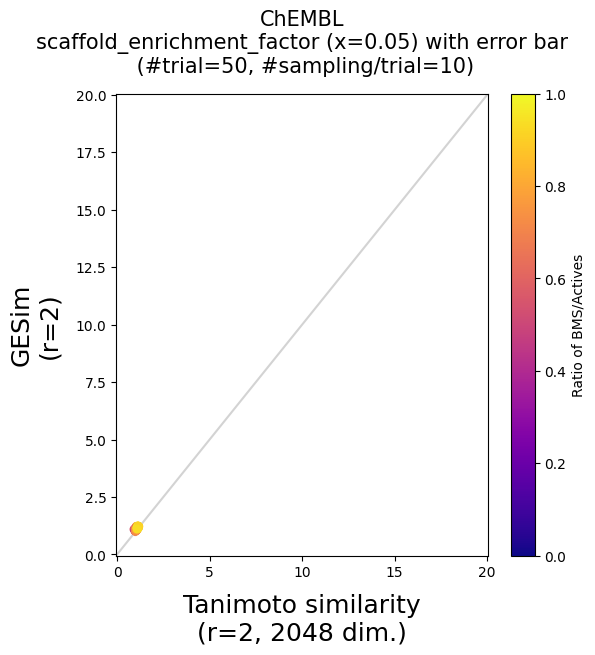

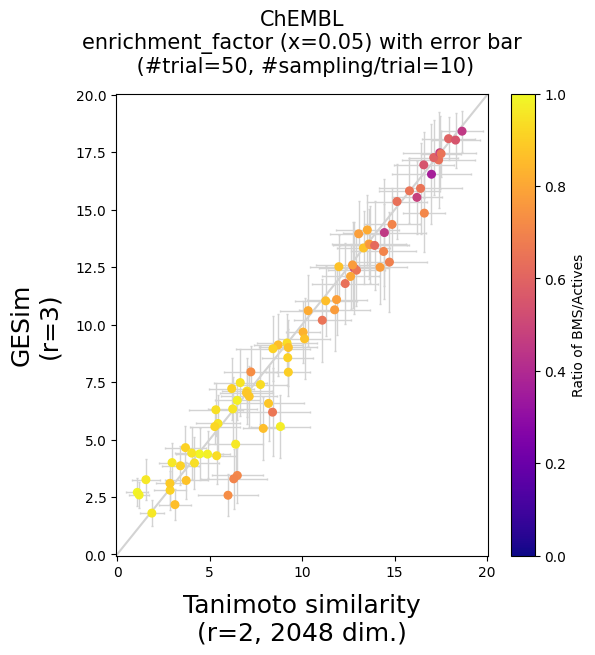

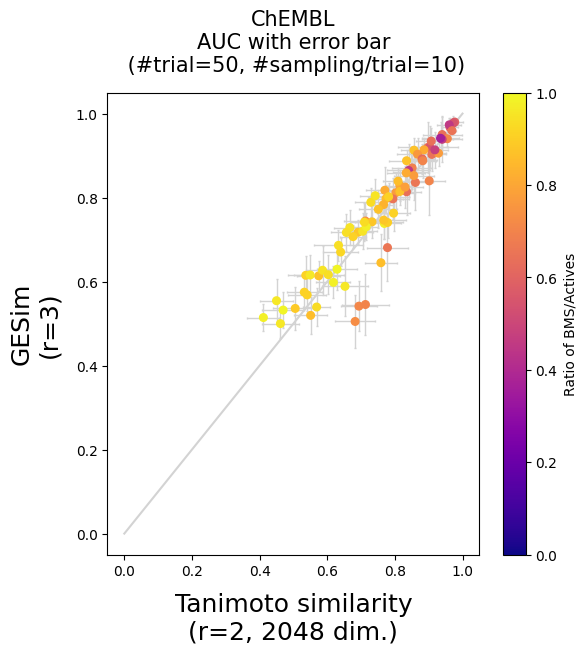

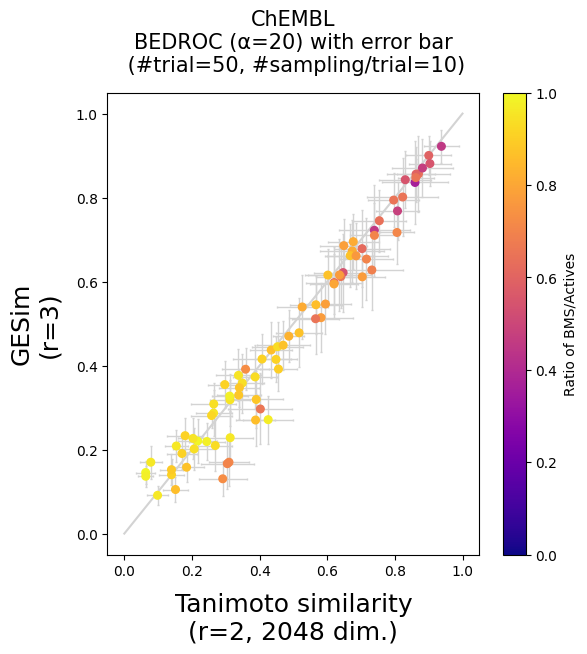

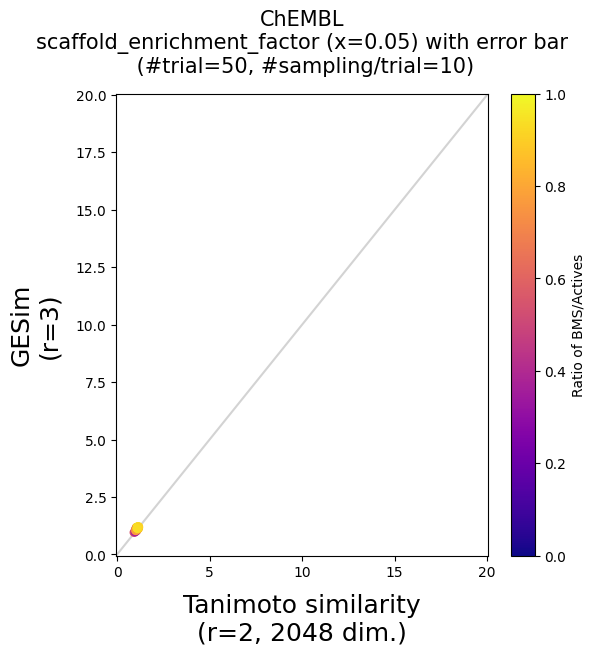

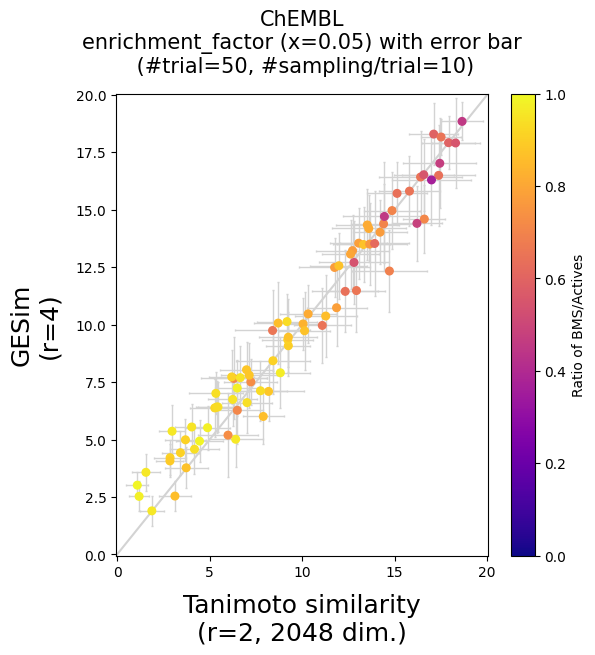

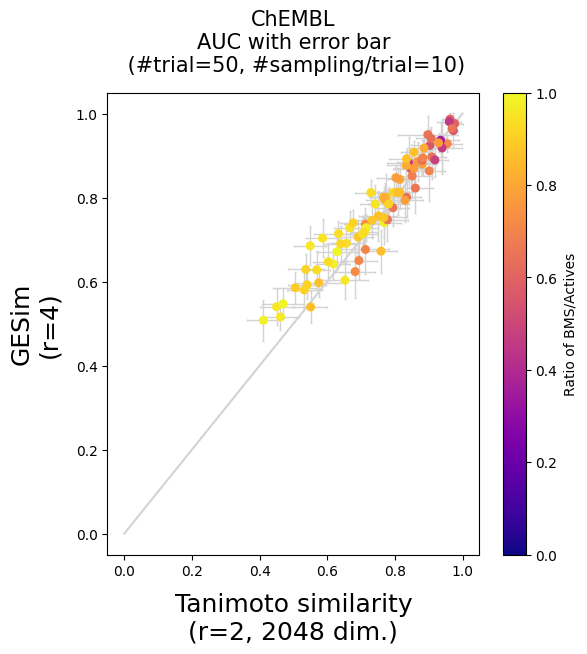

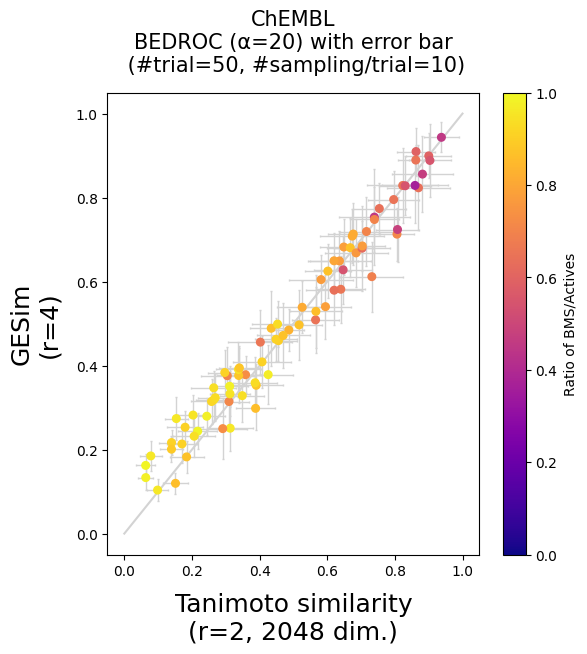

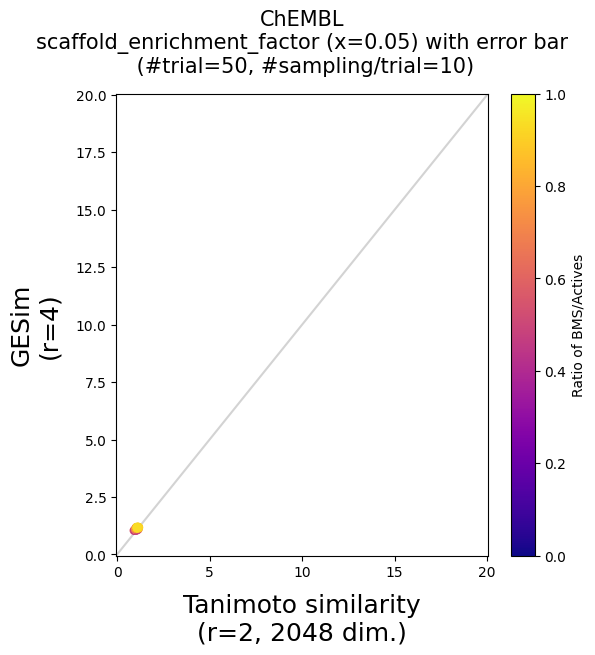

In [146]:
plot_all_methods_performance(tani_a20_f005_stat, ge_r1_a20_f005_stat, 'ChEMBL', target_labels,
                            target_ba_ratio_dict, alpha=20, fraction=0.05, gesim_r=1)
plot_all_methods_performance(tani_a20_f005_stat, ge_r2_a20_f005_stat, 'ChEMBL', target_labels,
                            target_ba_ratio_dict, alpha=20, fraction=0.05, gesim_r=2)
plot_all_methods_performance(tani_a20_f005_stat, ge_r3_a20_f005_stat, 'ChEMBL', target_labels,
                            target_ba_ratio_dict, alpha=20, fraction=0.05, gesim_r=3)
plot_all_methods_performance(tani_a20_f005_stat, ge_r4_a20_f005_stat, 'ChEMBL', target_labels,
                            target_ba_ratio_dict, alpha=20, fraction=0.05, gesim_r=4)